In [ ]:
!pip install matplotlib_venn

In [3]:
import json
import os
from collections import Counter
import requests
import numpy as np
from tqdm import tqdm
from wikidata.client import Client

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib_venn import venn3, venn3_circles
from matplotlib_venn import venn2, venn2_circles

from rdflib import Graph, URIRef, Literal
from rdflib.namespace import OWL, RDFS, XSD

# DISTRIBUTION OF WLS CLAIMS ON TOP 10 PROPERTIES PER DATASET

In [4]:
def req_labels(wiki_id):
    client = Client()           
    entity = client.get(wiki_id, load=True)
    return entity.label.texts['en']

In [5]:
def draw_bar(qualif, depr, null, norm, label):
    temp = {k: qualif.get(k, 0) + depr.get(k, 0) for k in set(qualif) | set(depr)}
    temp1 = {k: temp.get(k, 0) + null.get(k, 0) for k in set(temp) | set(null)}
    temp2 = {k: temp1.get(k, 0) + norm.get(k, 0) for k in set(temp1) | set(norm)}

    sortedProperties = sorted(temp2.items(), key=lambda x:x[1], reverse=True)
    converted_dict = dict(sortedProperties[:20])
    
    ns_list_of_tuples,na_list_of_tuples,nv_list_of_tuples, norm_list_of_tuples = [],[],[],[]
    
    for x in converted_dict:
        if x in qualif.keys():
            ns_list_of_tuples.append((x,qualif[x]))
        else:
            ns_list_of_tuples.append((x,0))
            
    for x in converted_dict:
        if x in null.keys():
            nv_list_of_tuples.append((x,null[x]))
        else:
            nv_list_of_tuples.append((x,0))
        
    for x in converted_dict:
        if x in depr.keys():
            na_list_of_tuples.append((x,depr[x]))
        else:
            na_list_of_tuples.append((x,0))
            
    for x in converted_dict:
        if x in norm.keys():
            norm_list_of_tuples.append((x,norm[x]))
        else:
            norm_list_of_tuples.append((x,0))
    
    l1, l2 = [], []
    x = 0
    while x < len(na_list_of_tuples):
        l1.append(int(na_list_of_tuples[x][1] + nv_list_of_tuples[x][1]))
        l2.append(int(na_list_of_tuples[x][1] + nv_list_of_tuples[x][1] + ns_list_of_tuples[x][1]))
        x+=1

    fig, ax = plt.subplots(figsize=(5, 5))
    plt.bar(range(len(na_list_of_tuples)), [na[1] for na in na_list_of_tuples], align='center') 
    plt.bar(range(len(nv_list_of_tuples)), [nv[1] for nv in nv_list_of_tuples], bottom=[na[1] for na in na_list_of_tuples], align='center')
    plt.bar(range(len(ns_list_of_tuples)), [ns[1] for ns in ns_list_of_tuples], bottom=l1, align='center') 
    plt.bar(range(len(norm_list_of_tuples)), [nn[1] for nn in norm_list_of_tuples], bottom=l2, align='center') 
    #plt.xticks(range(len(labels)), [v for k,v in labels.items()])
    plt.xticks(range(len(na_list_of_tuples)), [na[0] for na in na_list_of_tuples])
    ax.set_title(label)
    ax.set_xlabel('properties')
    plt.xticks(rotation=90)
    plt.yscale('log')
    ax.set_ylabel('occurrences')
    labels_set = ['Non-asserted:Deprecated', 'Null-valued', 'WLS qualified','Non-asserted:Normal']
    plt.legend(labels_set,loc=1)
    #plt.show()
    return plt

In [6]:
def get_norm(na_dict, depr_dict):
    norm_dict = {}
    for v in na_dict:
        if v not in depr_dict:
            norm_dict.update({v:na_dict[v]})
        else:
            norm_dict.update({v:na_dict[v]-depr_dict[v]})
            
    return norm_dict

In [ ]:
def get_json(file_path):
    ...

Get Audio-Visual data 

In [7]:
pop = {'P161': 1349943, 'P31': 1289168, 'P577': 851901, 'P136': 757716, 'P495': 543711, 'P175': 455595, 'P646': 406407, 'P2671': 388170, 'P345': 385605, 'P364': 376587}

pop_qualif = {'P2047': 1130, 'P5021': 284, 'P571': 144, 'P364': 134, 'P577': 77, 'P2408': 48, 'P840': 38, 'P2130': 35, 'P86': 22, 'P725': 9, 'P2754': 8, 'P2283': 8, 'P2142': 7, 'P3575': 6, 'P144': 6, 'P400': 5, 'P31': 5, 'P2664': 5, 'P921': 5, 'P580': 5}
pop_depr = {'P6398': 1282, 'P9586': 1231, 'P1265': 543, 'P6127': 495, 'P856': 460, 'P1827': 341, 'P577': 251, 'P4947': 240, 'P345': 218, 'P161': 210, 'P4983': 116, 'P58': 108, 'P57': 96, 'P435': 77, 'P86': 75, 'P5241': 72, 'P348': 64, 'P162': 54, 'P1476': 53, 'P2002': 44}
pop_null = {'P364': 30497, 'P155': 9147, 'P162': 5594, 'P345': 1718, 'P161': 956, 'P156': 642, 'P676': 192, 'P444': 182, 'P2522': 164, 'P577': 136, 'P8303': 102, 'P8895': 83, 'P527': 82, 'P4276': 62, 'P2639': 59, 'P1476': 51, 'P407': 44, 'P344': 42, 'P2364': 40, 'P264': 39}
pop_na = {'P8687': 9386, 'P348': 8932, 'P175': 6284, 'P577': 2672, 'P161': 2328, 'P1476': 1423, 'P6398': 1282, 'P9586': 1231, 'P856': 835, 'P6127': 650, 'P364': 562, 'P1265': 543, 'P1827': 488, 'P921': 292, 'P407': 271, 'P4947': 241, 'P345': 229, 'P449': 218, 'P31': 202, 'P154': 189, 'P86': 182, 'P136': 166, 'P371': 150, 'P58': 148, 'P18': 141, 'P400': 141, 'P57': 126, 'P676': 119, 'P1651': 117, 'P4983': 116, 'P725': 111, 'P162': 109, 'P495': 104, 'P840': 96, 'P6262': 92, 'P435': 85, 'P1324': 83, 'P272': 82, 'P1113': 76, 'P5241': 72, 'P2047': 68, 'P2002': 66, 'P123': 64, 'P2437': 62, 'P2664': 55, 'P264': 47, 'P2816': 46, 'P437': 41, 'P750': 40, 'P2142': 40, 'P527': 39, 'P436': 39, 'P2572': 35, 'P1954': 34, 'P5794': 33, 'P580': 32, 'P2397': 32, 'P3383': 31, 'P3418': 31, 'P179': 30, 'P1258': 29, 'P674': 29, 'P915': 28, 'P155': 27, 'P8856': 26, 'P4908': 25, 'P870': 25, 'P1804': 24, 'P156': 24, 'P3808': 24, 'P2671': 23, 'P5021': 23, 'P1933': 23, 'P8889': 23, 'P268': 22, 'P571': 21, 'P1019': 21, 'P2013': 20, 'P244': 20, 'P291': 20, 'P2205': 20, 'P214': 19, 'P5749': 19, 'P4073': 18, 'P2684': 18, 'P115': 18, 'P7937': 17, 'P1552': 17, 'P3077': 17, 'P275': 17, 'P2747': 17, 'P178': 16, 'P1733': 16, 'P2913': 16, 'P8419': 15, 'P227': 15, 'P361': 15, 'P582': 14, 'P144': 14, 'P1657': 14, 'P908': 14, 'P973': 14, 'P5072': 14, 'P1712': 13, 'P2629': 13, 'P1448': 12, 'P646': 11, 'P344': 11, 'P2554': 11, 'P1874': 11, 'P7335': 11, 'P306': 11, 'P408': 11, 'P3861': 11, 'P3575': 11, 'P4685': 10, 'P6783': 10, 'P658': 10, 'P9146': 10, 'P1191': 9, 'P3121': 9, 'P2003': 9, 'P1729': 9, 'P1680': 9, 'P5436': 9, 'P2408': 8, 'P444': 8, 'P9702': 8, 'P9297': 8, 'P1730': 8, 'P2206': 8, 'P3553': 8, 'P827': 8, 'P1040': 7, 'P905': 7, 'P138': 7, 'P2638': 7, 'P479': 7, 'P6381': 7, 'P4404': 7, 'P9345': 7, 'P6942': 7, 'P7107': 7, 'P170': 6, 'P2603': 6, 'P2758': 6, 'P404': 6, 'P10': 6, 'P276': 6, 'P710': 6, 'P2281': 6, 'P9086': 6, 'P3417': 5, 'P793': 5, 'P2346': 5, 'P2363': 5, 'P3961': 5, 'P5028': 5, 'P7919': 5, 'P826': 5, 'P3301': 5, 'P4894': 5, 'P1661': 5, 'P1581': 5, 'P2014': 4, 'P3984': 4, 'P4529': 4, 'P1981': 4, 'P6216': 4, 'P7975': 4, 'P166': 4, 'P3414': 4, 'P4015': 4, 'P724': 4, 'P8351': 4, 'P4769': 4, 'P4467': 4, 'P5944': 4, 'P277': 4, 'P2635': 4, 'P6218': 4, 'P6817': 4, 'P1613': 4, 'P1110': 4, 'P4860': 4, 'P6437': 4, 'P10135': 4, 'P910': 3, 'P373': 3, 'P2826': 3, 'P5786': 3, 'P4300': 3, 'P6839': 3, 'P5357': 3, 'P17': 3, 'P3804': 3, 'P3402': 3, 'P6562': 3, 'P1431': 3, 'P767': 3, 'P4632': 3, 'P7294': 3, 'P6949': 3, 'P1401': 3, 'P1873': 3, 'P8326': 3, 'P7429': 3, 'P972': 3, 'P5027': 3, 'P6466': 3, 'P7595': 3, 'P8847': 3, 'P3579': 3, 'P1813': 3, 'P9968': 3, 'P1994': 3, 'P3906': 3, 'P5202': 3, 'P51': 3, 'P7101': 3, 'P4647': 3, 'P3132': 3, 'P3442': 3, 'P2561': 3, 'P2078': 3, 'P5387': 3, 'P2541': 3, 'P30': 3, 'P3454': 3, 'P1881': 2, 'P2130': 2, 'P2639': 2, 'P3302': 2, 'P4835': 2, 'P1877': 2, 'P5099': 2, 'P2438': 2, 'P195': 2, 'P1417': 2, 'P50': 2, 'P8013': 2, 'P2518': 2, 'P8033': 2, 'P3933': 2, 'P3844': 2, 'P3092': 2, 'P2754': 2, 'P3216': 2, 'P5494': 2, 'P4965': 2, 'P7117': 2, 'P2858': 2, 'P7875': 2, 'P4806': 2, 'P852': 2, 'P7591': 2, 'P9777': 2, 'P3156': 2, 'P2207': 2, 'P3192': 2, 'P3141': 2, 'P4437': 2, 'P243': 2, 'P2283': 2, 'P4342': 2, 'P528': 2, 'P5916': 2, 'P4162': 2, 'P1482': 2, 'P2037': 2, 'P3499': 2, 'P5030': 2, 'P2550': 2, 'P7014': 2, 'P8972': 2, 'P1889': 1, 'P3138': 1, 'P3143': 1, 'P1970': 1, 'P5510': 1, 'P1811': 1, 'P1434': 1, 'P941': 1, 'P2756': 1, 'P1562': 1, 'P2465': 1, 'P4780': 1, 'P4783': 1, 'P942': 1, 'P2704': 1, 'P2364': 1, 'P2061': 1, 'P4665': 1, 'P3306': 1, 'P3135': 1, 'P5693': 1, 'P1814': 1, 'P8055': 1, 'P3593': 1, 'P5885': 1, 'P5247': 1, 'P7564': 1, 'P10586': 1, 'P4477': 1, 'P6717': 1, 'P9075': 1, 'P10030': 1, 'P6827': 1, 'P7852': 1, 'P655': 1, 'P3180': 1, 'P6278': 1, 'P7005': 1, 'P950': 1, 'P8411': 1, 'P4945': 1, 'P953': 1, 'P3931': 1, 'P2284': 1, 'P8018': 1, 'P3185': 1, 'P5838': 1, 'P483': 1, 'P585': 1, 'P1444': 1, 'P4919': 1, 'P8028': 1, 'P5152': 1, 'P406': 1, 'P6181': 1, 'P1433': 1, 'P5201': 1, 'P5331': 1, 'P5659': 1, 'P6760': 1, 'P8672': 1, 'P9866': 1, 'P7622': 1, 'P2723': 1, 'P2908': 1, 'P3962': 1, 'P3818': 1, 'P1972': 1, 'P6666': 1, 'P6665': 1, 'P1243': 1, 'P3265': 1, 'P839': 1, 'P2670': 1, 'P9214': 1, 'P180': 1, 'P7085': 1, 'P5646': 1, 'P691': 1, 'P1132': 1, 'P7293': 1, 'P1922': 1, 'P4086': 1, 'P7998': 1, 'P2847': 1, 'P2079': 1, 'P1346': 1, 'P3308': 1, 'P4199': 1, 'P7705': 1, 'P137': 1, 'P4175': 1, 'P488': 1, 'P131': 1, 'P2699': 1, 'P7324': 1, 'P2896': 1, 'P9024': 1, 'P8607': 1, 'P8900': 1, 'P3222': 1, 'P1267': 1, 'P7427': 1, 'P5829': 1, 'P8546': 1, 'P3030': 1, 'P1535': 1, 'P3893': 1, 'P7703': 1, 'P9601': 1, 'P7921': 1, 'P3483': 1, 'P159': 1, 'P4082': 1, 'P8179': 1, 'P349': 1, 'P6081': 1, 'P2347': 1, 'P2850': 1, 'P1037': 1, 'P837': 1, 'P6079': 1, 'P1684': 1, 'P1447': 1, 'P1547': 1, 'P1416': 1, 'P7956': 1, 'P1616': 1, 'P5260': 1, 'P7699': 1, 'P8934': 1, 'P6720': 1, 'P2530': 0, 'P4969': 0, 'P7818': 0, 'P1424': 0, 'P480': 0, 'P462': 0, 'P2529': 0, 'P3145': 0, 'P3495': 0, 'P3107': 0, 'P5032': 0, 'P5327': 0, 'P9918': 0, 'P7212': 0, 'P8189': 0, 'P949': 0, 'P989': 0, 'P2769': 0, 'P1705': 0, 'P3219': 0, 'P8895': 0, 'P4438': 0, 'P2703': 0, 'P7285': 0, 'P5253': 0, 'P1985': 0, 'P1343': 0, 'P2581': 0, 'P2512': 0, 'P8345': 0, 'P10291': 0, 'P6472': 0, 'P5382': 0, 'P8309': 0, 'P1445': 0, 'P1151': 0, 'P948': 0, 'P5905': 0, 'P6104': 0, 'P7970': 0, 'P4786': 0, 'P7741': 0, 'P2334': 0, 'P8296': 0, 'P2515': 0, 'P7704': 0, 'P2624': 0, 'P8278': 0, 'P7043': 0, 'P7334': 0, 'P3340': 0, 'P4209': 0, 'P5970': 0, 'P2631': 0, 'P4282': 0, 'P641': 0, 'P4515': 0, 'P9022': 0, 'P4277': 0, 'P3367': 0, 'P5128': 0, 'P3834': 0, 'P2508': 0, 'P2883': 0, 'P3129': 0, 'P8796': 0, 'P5820': 0, 'P3110': 0, 'P5680': 0, 'P2755': 0, 'P5150': 0, 'P4276': 0, 'P3212': 0, 'P3203': 0, 'P6658': 0, 'P6474': 0, 'P7519': 0, 'P7501': 0, 'P3803': 0, 'P5338': 0, 'P7777': 0, 'P6614': 0, 'P5108': 0, 'P3704': 0, 'P1269': 0, 'P3428': 0, 'P5990': 0, 'P6197': 0, 'P4816': 0, 'P4916': 0, 'P6337': 0, 'P6267': 0, 'P5971': 0, 'P7597': 0, 'P7877': 0, 'P8229': 0, 'P10096': 0, 'P10383': 0, 'P7886': 0, 'P2725': 0, 'P600': 0, 'P9747': 0, 'P9870': 0, 'P10475': 0, 'P8084': 0, 'P8042': 0, 'P2864': 0, 'P7909': 0, 'P7555': 0, 'P8023': 0, 'P8087': 0, 'P8364': 0, 'P5385': 0, 'P4705': 0, 'P4917': 0, 'P4847': 0, 'P6554': 0, 'P5999': 0, 'P914': 0, 'P1032': 0, 'P1411': 0, 'P8994': 0, 'P10371': 0, 'P10414': 0, 'P10501': 0, 'P6867': 0, 'P6774': 0, 'P5732': 0, 'P3280': 0, 'P5797': 0, 'P7936': 0, 'P8680': 0, 'P7327': 0, 'P10309': 0, 'P853': 0, 'P968': 0, 'P8019': 0, 'P2451': 0, 'P5780': 0, 'P7853': 0, 'P7516': 0, 'P9118': 0, 'P4151': 0, 'P1872': 0, 'P1638': 0, 'P3113': 0, 'P5017': 0, 'P7563': 0, 'P7707': 0, 'P3174': 0, 'P9806': 0, 'P4846': 0, 'P4671': 0, 'P7683': 0, 'P7981': 0, 'P4858': 0, 'P4859': 0, 'P5290': 0, 'P10348': 0, 'P8059': 0, 'P8076': 0, 'P279': 0, 'P8303': 0, 'P8333': 0, 'P2291': 0, 'P8392': 0, 'P9083': 0, 'P9182': 0, 'P6718': 0, 'P2724': 0, 'P5197': 0, 'P5915': 0, 'P3040': 0, 'P4839': 0, 'P1407': 0, 'P1427': 0, 'P9143': 0, 'P6913': 0, 'P8040': 0, 'P2093': 0, 'P10379': 0, 'P4710': 0, 'P4961': 0, 'P5585': 0, 'P2669': 0, 'P7541': 0, 'P6032': 0, 'P3139': 0, 'P4608': 0, 'P4513': 0, 'P3673': 0, 'P3851': 0, 'P9697': 0, 'P10354': 0, 'P7306': 0, 'P8268': 0, 'P9709': 0, 'P10144': 0, 'P4962': 0, 'P6359': 0, 'P8531': 0, 'P4606': 0, 'P9821': 0, 'P4013': 0, 'P1237': 0, 'P2509': 0, 'P9067': 0, 'P9701': 0, 'P5311': 0, 'P6133': 0, 'P6458': 0, 'P8918': 0, 'P6584': 0, 'P5987': 0, 'P8958': 0, 'P9215': 0, 'P7299': 0, 'P7091': 0, 'P7236': 0, 'P7222': 0, 'P2970': 0, 'P6145': 0, 'P10239': 0, 'P3868': 0, 'P7953': 0, 'P4805': 0, 'P8408': 0, 'P3095': 0, 'P7132': 0, 'P9205': 0, 'P9367': 0, 'P5091': 0, 'P2899': 0, 'P287': 0, 'P3943': 0, 'P6452': 0, 'P3787': 0, 'P443': 0, 'P5138': 0, 'P2348': 0, 'P5196': 0, 'P7968': 0, 'P4845': 0, 'P916': 0, 'P8256': 0, 'P8420': 0, 'P5737': 0, 'P6444': 0, 'P8670': 0, 'P8279': 0, 'P5008': 0, 'P10356': 0, 'P6256': 0, 'P1344': 0, 'P9857': 0, 'P10357': 0, 'P2094': 0, 'P286': 0, 'P3785': 0, 'P7573': 0, 'P135': 0, 'P822': 0, 'P460': 0, 'P10171': 0, 'P8304': 0, 'P6802': 0, 'P3080': 0, 'P7913': 0, 'P10455': 0, 'P7702': 0, 'P6517': 0, 'P8090': 0, 'P8020': 0, 'P9877': 0, 'P7785': 0, 'P6367': 0, 'P8782': 0, 'P7915': 0, 'P10100': 0, 'P6363': 0, 'P2606': 0, 'P5940': 0, 'P7774': 0, 'P2739': 0, 'P4933': 0, 'P9584': 0, 'P212': 0, 'P6229': 0, 'P7067': 0, 'P2819': 0, 'P7166': 0, 'P2721': 0, 'P2678': 0, 'P5791': 0, 'P5384': 0, 'P2637': 0, 'P2636': 0, 'P7140': 0, 'P10187': 0, 'P3128': 0, 'P1695': 0, 'P1273': 0, 'P9203': 0, 'P9984': 0, 'P4027': 0, 'P1829': 0, 'P1236': 0, 'P5218': 0, 'P1934': 0, 'P8295': 0, 'P8313': 0, 'P5126': 0, 'P2860': 0, 'P8674': 0, 'P5098': 0, 'P8673': 0, 'P8920': 0, 'P737': 0, 'P508': 0, 'P2400': 0, 'P6623': 0, 'P3854': 0, 'P10248': 0, 'P10353': 0, 'P10390': 0, 'P10365': 0, 'P10393': 0, 'P10507': 0, 'P7017': 0, 'P7518': 0, 'P747': 0, 'P106': 0, 'P6748': 0, 'P6931': 0, 'P9089': 0, 'P736': 0, 'P1558': 0, 'P825': 0, 'P4932': 0, 'P3445': 0, 'P5146': 0, 'P7458': 0, 'P9090': 0, 'P7517': 0, 'P5345': 0, 'P7370': 0, 'P7669': 0, 'P6928': 0, 'P7751': 0, 'P10169': 0, 'P10137': 0, 'P9744': 0, 'P9133': 0, 'P1725': 0, 'P3300': 0, 'P6549': 0, 'P3821': 0, 'P6080': 0, 'P4210': 0, 'P4211': 0, 'P6217': 0, 'P1292': 0, 'P10262': 0, 'P1449': 0, 'P7143': 0, 'P648': 0, 'P1259': 0, 'P186': 0, 'P1114': 0, 'P5813': 0, 'P935': 0, 'P7899': 0, 'P576': 0, 'P5151': 0, 'P110': 0, 'P4748': 0, 'P7274': 0, 'P5881': 0, 'P5453': 0, 'P6068': 0, 'P9636': 0, 'P2354': 0, 'P1625': 0, 'P629': 0, 'P5059': 0, 'P5229': 0, 'P1923': 0, 'P664': 0, 'P2499': 0, 'P393': 0, 'P1350': 0, 'P2500': 0, 'P213': 0, 'P1619': 0, 'P3999': 0, 'P1366': 0, 'P7859': 0, 'P6291': 0, 'P2279': 0, 'P1435': 0, 'P7665': 0, 'P2416': 0, 'P366': 0, 'P1325': 0, 'P6151': 0, 'P5337': 0, 'P8350': 0, 'P5842': 0, 'P5733': 0, 'P880': 0, 'P3836': 0, 'P5083': 0, 'P8035': 0, 'P9979': 0, 'P2031': 0, 'P4960': 0, 'P7881': 0, 'P7649': 0, 'P5590': 0, 'P127': 0, 'P1056': 0, 'P3995': 0, 'P2888': 0, 'P3597': 0, 'P4435': 0, 'P5116': 0, 'P4655': 0, 'P9618': 0, 'P6992': 0, 'P4857': 0, 'P88': 0, 'P6451': 0, 'P8874': 0, 'P8908': 0, 'P8921': 0, 'P9965': 0, 'P118': 0, 'P8524': 0, 'P6383': 0, 'P5495': 0, 'P1809': 0, 'P625': 0, 'P434': 0, 'P859': 0, 'P8324': 0, 'P6853': 0, 'P5845': 0, 'P5707': 0, 'P8800': 0, 'P3650': 0, 'P2687': 0, 'P269': 0, 'P7055': 0, 'P9068': 0, 'P4135': 0, 'P9987': 0, 'P854': 0, 'P8729': 0, 'P6292': 0, 'P9078': 0, 'P2984': 0, 'P943': 0, 'P7799': 0, 'P7828': 0, 'P7871': 0, 'P8901': 0, 'P4110': 0, 'P608': 0, 'P3450': 0, 'P3342': 0, 'P1054': 0, 'P6172': 0, 'P9007': 0, 'P9010': 0, 'P1451': 0, 'P9003': 0, 'P9006': 0, 'P9005': 0, 'P9008': 0, 'P7583': 0, 'P4818': 0, 'P5840': 0, 'P112': 0, 'P9014': 0, 'P1329': 0, 'P9012': 0, 'P10150': 0, 'P9011': 0, 'P9004': 0, 'P5988': 0, 'P10295': 0, 'P9035': 0, 'P1594': 0, 'P5233': 0, 'P805': 0, 'P4354': 0, 'P5860': 0, 'P6932': 0, 'P7978': 0, 'P7118': 0, 'P6455': 0, 'P6456': 0, 'P7611': 0, 'P8811': 0, 'P9177': 0, 'P103': 0, 'P9897': 0, 'P98': 0, 'P963': 0, 'P217': 0, 'P5249': 0, 'P5318': 0, 'P6058': 0, 'P7840': 0, 'P5933': 0, 'P1716': 0, 'P9882': 0, 'P10286': 0, 'P4518': 0, 'P2184': 0, 'P9793': 0, 'P1441': 0, 'P7739': 0, 'P7966': 0, 'P7967': 0, 'P8443': 0, 'P7788': 0, 'P7679': 0, 'P2043': 0, 'P2522': 0, 'P1013': 0, 'P6166': 0, 'P10269': 0, 'P828': 0, 'P1235': 0, 'P7192': 0, 'P4035': 0, 'P1316': 0, 'P1984': 0, 'P2360': 0, 'P87': 0, 'P3996': 0, 'P4072': 0, 'P4483': 0, 'P8885': 0, 'P1104': 0, 'P10615': 0, 'P3929': 0, 'P3463': 0, 'P5849': 0, 'P4087': 0, 'P4834': 0, 'P5925': 0, 'P6348': 0, 'P2163': 0, 'P9290': 0, 'P575': 0, 'P2555': 0, 'P3025': 0, 'P6816': 0, 'P7775': 0, 'P6797': 0, 'P4985': 0, 'P5865': 0, 'P2373': 0, 'P5302': 0, 'P8201': 0, 'P10045': 0, 'P2652': 0, 'P6299': 0, 'P7733': 0, 'P7802': 0, 'P6900': 0, 'P4021': 0, 'P7737': 0, 'P8606': 0, 'P2209': 0, 'P8261': 0, 'P10537': 0, 'P1029': 0, 'P7760': 0, 'P8298': 0, 'P8435': 0, 'P5144': 0, 'P5153': 0, 'P4577': 0, 'P8663': 0, 'P4578': 0, 'P9899': 0, 'P478': 0, 'P1896': 0, 'P409': 0, 'P7003': 0, 'P957': 0, 'P2969': 0, 'P8383': 0, 'P2236': 0, 'P3267': 0, 'P5171': 0, 'P4312': 0, 'P3218': 0, 'P3750': 0, 'P7892': 0, 'P176': 0, 'P6962': 0, 'P3458': 0, 'P6150': 0, 'P8371': 0, 'P2897': 0, 'P6467': 0, 'P5161': 0, 'P9237': 0, 'P9028': 0, 'P4290': 0, 'P4387': 0, 'P7701': 0, 'P2001': 0, 'P6195': 0, 'P2537': 0, 'P4107': 0, 'P6898': 0, 'P7734': 0, 'P2849': 0, 'P9852': 0, 'P7985': 0, 'P10167': 0, 'P7593': 0, 'P4092': 0, 'P1071': 0, 'P4104': 0, 'P7826': 0, 'P7994': 0, 'P8003': 0, 'P7811': 0, 'P6742': 0, 'P7592': 0, 'P2124': 0, 'P6461': 0, 'P7812': 0, 'P2441': 0, 'P2341': 0, 'P1801': 0, 'P7432': 0, 'P3473': 0, 'P6182': 0, 'P8066': 0, 'P4271': 0, 'P7567': 0, 'P2125': 0, 'P1545': 0, 'P9895': 0, 'P9100': 0, 'P8525': 0, 'P6621': 0, 'P8092': 0, 'P4763': 0, 'P9816': 0, 'P8768': 0, 'P9885': 0, 'P1542': 0, 'P2139': 0, 'P10120': 0, 'P10297': 0, 'P6157': 0, 'P10027': 0, 'P10225': 0, 'P1414': 0, 'P7502': 0, 'P1641': 0, 'P10437': 0, 'P10453': 0, 'P10509': 0, 'P10482': 0, 'P9318': 0, 'P1532': 0, 'P548': 0, 'P9461': 0, 'P3838': 0, 'P6459': 0, 'P2088': 0, 'P1085': 0, 'P2067': 0, 'P2049': 0, 'P2048': 0, 'P4330': 0, 'P3502': 0, 'P8144': 0, 'P10267': 0, 'P9745': 0, 'P10424': 0, 'P3959': 0, 'P7731': 0, 'P7879': 0, 'P1142': 0, 'P5051': 0, 'P7955': 0, 'P2701': 0, 'P7810': 0, 'P7784': 0, 'P1219': 0, 'P4077': 0, 'P7747': 0, 'P8794': 0, 'P5655': 0, 'P7650': 0, 'P6134': 0, 'P1902': 0, 'P1439': 0, 'P7340': 0, 'P7823': 0, 'P7997': 0, 'P447': 0, 'P1274': 0, 'P6476': 0, 'P370': 0, 'P6721': 0, 'P1044': 0, 'P2928': 0, 'P9629': 0, 'P452': 0, 'P3283': 0, 'P1687': 0, 'P2910': 0, 'P7824': 0, 'P4701': 0, 'P7756': 0, 'P1327': 0, 'P7439': 0, 'P6570': 0, 'P1365': 0, 'P8827': 0, 'P4033': 0, 'P27': 0, 'P1004': 0, 'P729': 0, 'P7890': 0, 'P8776': 0, 'P8255': 0, 'P4579': 0, 'P6765': 0, 'P10633': 0, 'P7660': 0, 'P849': 0, 'P8646': 0, 'P9128': 0, 'P6439': 0, 'P3259': 0, 'P5159': 0, 'P6360': 0, 'P10178': 0, 'P10223': 0, 'P10330': 0, 'P10548': 0, 'P8940': 0, 'P3789': 0, 'P3816': 0, 'P2936': 0, 'P9602': 0, 'P7523': 0, 'P4970': 0, 'P6500': 0, 'P1025': 0, 'P6196': 0, 'P4793': 0, 'P4003': 0, 'P898': 0, 'P547': 0, 'P4264': 0, 'P10213': 0, 'P2257': 0, 'P8344': 0, 'P7512': 0, 'P3794': 0, 'P10255': 0, 'P10164': 0, 'P10454': 0, 'P360': 0, 'P3827': 0, 'P7175': 0, 'P9767': 0, 'P6086': 0, 'P2475': 0, 'P6251': 0, 'P9283': 0, 'P5163': 0, 'P1144': 0, 'P9009': 0, 'P2924': 0, 'P6412': 0, 'P3221': 0, 'P3479': 0, 'P1027': 0, 'P1225': 0, 'P4622': 0, 'P3509': 0, 'P2517': 0, 'P3569': 0, 'P1296': 0, 'P6200': 0, 'P9084': 0, 'P3847': 0, 'P8814': 0, 'P8349': 0, 'P7982': 0, 'P5019': 0, 'P10234': 0, 'P6449': 0, 'P9545': 0, 'P7867': 0, 'P248': 0, 'P2722': 0, 'P4198': 0, 'P3365': 0, 'P6643': 0, 'P10170': 0, 'P9820': 0, 'P8600': 0, 'P7305': 0, 'P8432': 0, 'P1953': 0, 'P358': 0, 'P1942': 0, 'P10352': 0, 'P2942': 0, 'P823': 0, 'P4431': 0, 'P9322': 0, 'P9751': 0, 'P1080': 0, 'P4584': 0, 'P2894': 0, 'P9152': 0, 'P6379': 0, 'P1454': 0, 'P1711': 0, 'P3500': 0, 'P2427': 0, 'P966': 0, 'P6366': 0, 'P3478': 0, 'P6782': 0, 'P3393': 0, 'P4527': 0, 'P10283': 0, 'P3057': 0, 'P8093': 0, 'P1128': 0, 'P6125': 0, 'P5571': 0, 'P3952': 0, 'P3085': 0, 'P8823': 0, 'P8974': 0, 'P6275': 0, 'P669': 0, 'P6228': 0, 'P3440': 0, 'P1670': 0, 'P6883': 0, 'P8816': 0, 'P10152': 0, 'P7763': 0, 'P7596': 0, 'P1412': 0, 'P1065': 0, 'P9549': 0, 'P1741': 0, 'P5882': 0, 'P7109': 0, 'P9589': 0, 'P5395': 0, 'P6981': 0, 'P236': 0, 'P8903': 0, 'P9477': 0, 'P996': 0, 'P7177': 0, 'P3258': 0, 'P7685': 0, 'P1652': 0, 'P6067': 0, 'P41': 0, 'P5769': 0, 'P4399': 0, 'P2390': 0, 'P4400': 0, 'P3977': 0, 'P4022': 0, 'P485': 0, 'P749': 0, 'P1408': 0, 'P5262': 0, 'P998': 0, 'P1352': 0, 'P8928': 0, 'P5485': 0, 'P906': 0, 'P1580': 0, 'P8294': 0, 'P9922': 0, 'P10173': 0, 'P8879': 0, 'P5164': 0, 'P101': 0, 'P10230': 0, 'P465': 0, 'P7761': 0, 'P659': 0, 'P7932': 0, 'P9810': 0, 'P5537': 0, 'P21': 0, 'P1739': 0, 'P4634': 0, 'P7901': 0, 'P607': 0, 'P2613': 0, 'P4854': 0, 'P8704': 0, 'P6361': 0, 'P2675': 0, 'P569': 0, 'P7808': 0, 'P3970': 0, 'P7318': 0, 'P3889': 0, 'P902': 0, 'P7056': 0, 'P1389': 0, 'P2000': 0, 'P5504': 0, 'P1573': 0, 'P740': 0, 'P1557': 0, 'P8363': 0, 'P2318': 0, 'P7204': 0, 'P4656': 0, 'P5024': 0, 'P9813': 0, 'P6221': 0, 'P2551': 0, 'P3705': 0, 'P9938': 0, 'P4779': 0, 'P9995': 0, 'P2011': 0, 'P3589': 0, 'P7277': 0, 'P5513': 0, 'P6520': 0, 'P3293': 0, 'P1319': 0, 'P6881': 0, 'P9204': 0, 'P8106': 0, 'P10110': 0, 'P8665': 0, 'P4784': 0, 'P10098': 0, 'P888': 0, 'P5875': 0, 'P800': 0, 'P4208': 0, 'P1728': 0, 'P1242': 0, 'P4746': 0, 'P2121': 0, 'P1303': 0, 'P10432': 0, 'P5255': 0, 'P10303': 0, 'P1015': 0, 'P1810': 0, 'P4619': 0, 'P7829': 0, 'P5932': 0, 'P2716': 0, 'P10495': 0, 'P8762': 0, 'P6947': 0, 'P1617': 0, 'P3106': 0, 'P8693': 0, 'P1754': 0, 'P6925': 0, 'P4032': 0, 'P37': 0, 'P634': 0, 'P6422': 0, 'P2679': 0, 'P945': 0, 'P3338': 0, 'P403': 0, 'P1548': 0, 'P4614': 0, 'P7689': 0, 'P7157': 0, 'P1968': 0, 'P3430': 0, 'P10006': 0, 'P7211': 0, 'P2267': 0, 'P3630': 0, 'P6573': 0, 'P4111': 0, 'P7822': 0, 'P189': 0, 'P1212': 0, 'P347': 0, 'P9394': 0, 'P1949': 0, 'P1257': 0, 'P5782': 0, 'P1669': 0, 'P5891': 0, 'P1256': 0, 'P7457': 0, 'P9092': 0, 'P1208': 0, 'P1998': 0, 'P505': 0, 'P2328': 0, 'P2649': 0, 'P1001': 0, 'P1036': 0, 'P4270': 0, 'P5792': 0, 'P433': 0, 'P1218': 0, 'P7284': 0, 'P6922': 0, 'P4204': 0, 'P7506': 0, 'P10275': 0, 'P5555': 0, 'P3272': 0, 'P6002': 0, 'P4144': 0, 'P6332': 0, 'P6368': 0, 'P6770': 0, 'P2242': 0, 'P1726': 0, 'P2386': 0, 'P61': 0, 'P2596': 0, 'P140': 0, 'P1355': 0, 'P1356': 0, 'P9465': 0, 'P2789': 0, 'P3225': 0, 'P6868': 0, 'P8652': 0, 'P4640': 0, 'P6657': 0, 'P5524': 0, 'P3279': 0, 'P7772': 0, 'P649': 0, 'P8916': 0, 'P4674': 0, 'P3241': 0, 'P2344': 0, 'P356': 0, 'P6020': 0, 'P7420': 0, 'P8923': 0, 'P481': 0, 'P1028': 0, 'P1207': 0, 'P3855': 0, 'P2610': 0, 'P6375': 0, 'P1679': 0, 'P3324': 0, 'P2582': 0, 'P5499': 0, 'P381': 0, 'P2186': 0, 'P762': 0, 'P4075': 0, 'P4380': 0, 'P9281': 0, 'P6723': 0, 'P4610': 0, 'P7153': 0, 'P1707': 0, 'P2046': 0, 'P8564': 0, 'P281': 0, 'P8334': 0, 'P1702': 0, 'P790': 0, 'P1371': 0, 'P6306': 0, 'P402': 0, 'P2795': 0, 'P1700': 0, 'P4868': 0, 'P10044': 0, 'P19': 0, 'P4219': 0, 'P149': 0, 'P1430': 0, 'P4244': 0, 'P2817': 0, 'P9339': 0, 'P8335': 0, 'P1639': 0, 'P4265': 0, 'P6464': 0, 'P461': 0, 'P4948': 0, 'P2959': 0, 'P9760': 0, 'P5004': 0, 'P6224': 0, 'P7228': 0, 'P126': 0, 'P7261': 0, 'P355': 0, 'P1649': 0, 'P1055': 0, 'P3194': 0, 'P2044': 0, 'P1566': 0, 'P6111': 0, 'P2770': 0, 'P5968': 0, 'P4756': 0, 'P2032': 0, 'P6762': 0, 'P4699': 0, 'P5184': 0, 'P1955': 0, 'P9287': 0, 'P10460': 0, 'P1875': 0, 'P3065': 0, 'P1686': 0, 'P6116': 0, 'P1479': 0, 'P4733': 0, 'P742': 0, 'P6552': 0, 'P9863': 0, 'P553': 0, 'P8001': 0, 'P735': 0, 'P69': 0, 'P54': 0, 'P8286': 0, 'P570': 0, 'P4646': 0, 'P3899': 0, 'P4566': 0, 'P1947': 0, 'P7923': 0, 'P6418': 0, 'P5204': 0, 'P5432': 0, 'P7749': 0, 'P453': 0, 'P6445': 0, 'P9466': 0, 'P971': 0, 'P1184': 0, 'P9848': 0, 'P1317': 0, 'P1398': 0, 'P8731': 0, 'P6454': 0, 'P6250': 0, 'P2922': 0, 'P1766': 0, 'P3108': 0, 'P3749': 0, 'P6369': 0, 'P3275': 0, 'P10549': 0, 'P9032': 0, 'P1752': 0, 'P5505': 0, 'P2882': 0, 'P2812': 0, 'P10617': 0, 'P7037': 0, 'P5846': 0, 'P4683': 0, 'P6108': 0, 'P6338': 0, 'P242': 0, 'P7648': 0, 'P9976': 0, 'P4353': 0, 'P10386': 0, 'P5026': 0, 'P10344': 0, 'P5360': 0, 'P3912': 0, 'P108': 0, 'P1050': 0, 'P7604': 0, 'P1546': 0, 'P8360': 0, 'P3482': 0, 'P9614': 0, 'P208': 0, 'P143': 0, 'P792': 0, 'P7827': 0, 'P2868': 0, 'P304': 0, 'P698': 0, 'P5995': 0, 'P5909': 0, 'P7193': 0, 'P9657': 0, 'P10242': 0, 'P6679': 0, 'P463': 0, 'P5460': 0, 'P1268': 0, 'P3320': 0, 'P10335': 0, 'P5935': 0, 'P5880': 0, 'P5251': 0, 'P92': 0, 'P6870': 0, 'P5063': 0, 'P1559': 0, 'P7314': 0, 'P7588': 0, 'P7081': 0, 'P5123': 0, 'P3155': 0, 'P1382': 0, 'P7087': 0, 'P8343': 0, 'P9202': 0, 'P8315': 0, 'P3967': 0, 'P1072': 0, 'P1073': 0, 'P2179': 0, 'P4272': 0, 'P6559': 0, 'P1830': 0, 'P6686': 0, 'P2992': 0, 'P6738': 0, 'P3744': 0, 'P7816': 0, 'P7194': 0, 'P2737': 0, 'P3790': 0, 'P7400': 0, 'P5404': 0, 'P9743': 0, 'P2622': 0, 'P6431': 0, 'P4773': 0, 'P2605': 0, 'P2604': 0, 'P6886': 0, 'P6540': 0, 'P10279': 0, 'P1844': 0, 'P3740': 0, 'P7695': 0, 'P1891': 0, 'P8125': 0, 'P1315': 0, 'P183': 0, 'P8359': 0, 'P6283': 0, 'P4411': 0, 'P94': 0, 'P8772': 0, 'P2389': 0, 'P9869': 0, 'P1387': 0, 'P415': 0, 'P6122': 0, 'P3938': 0, 'P1842': 0, 'P518': 0, 'P4861': 0, 'P1297': 0, 'P421': 0, 'P1612': 0, 'P6016': 0, 'P1351': 0, 'P1359': 0, 'P2089': 0, 'P2893': 0, 'P7213': 0, 'P9937': 0, 'P6110': 0, 'P791': 0, 'P6698': 0, 'P958': 0, 'P6325': 0, 'P1005': 0, 'P967': 0, 'P1706': 0, 'P675': 0, 'P730': 0, 'P5047': 0, 'P642': 0, 'P6010': 0, 'P282': 0, 'P4870': 0, 'P10025': 0, 'P7477': 0, 'P1890': 0, 'P8836': 0, 'P9234': 0, 'P7075': 0, 'P8267': 0, 'P2813': 0, 'P1534': 0, 'P6011': 0, 'P4444': 0, 'P3634': 0, 'P7897': 0, 'P8732': 0, 'P7033': 0, 'P1368': 0, 'P913': 0, 'P10063': 0, 'P7690': 0, 'P467': 0, 'P8325': 0, 'P4097': 0, 'P6353': 0, 'P7317': 0, 'P7223': 0, 'P4724': 0, 'P1640': 0, 'P1051': 0, 'P5107': 0, 'P3721': 0, 'P4254': 0, 'P1828': 0, 'P6180': 0, 'P1283': 0, 'P2336': 0, 'P9023': 0, 'P831': 0, 'P5719': 0, 'P734': 0, 'P7418': 0, 'P9873': 0, 'P1182': 0, 'P5587': 0, 'P8791': 0, 'P4560': 0, 'P3646': 0, 'P10208': 0, 'P10185': 0, 'P1014': 0, 'P7448': 0, 'P7585': 0, 'P1092': 0, 'P3845': 0, 'P9831': 0, 'P3733': 0, 'P3997': 0, 'P1149': 0, 'P5266': 0, 'P2700': 0, 'P5058': 0, 'P3876': 0, 'P8979': 0, 'P5421': 0, 'P5652': 0, 'P9478': 0, 'P3116': 0, 'P2453': 0, 'P5140': 0, 'P1375': 0, 'P7872': 0, 'P706': 0, 'P6914': 0, 'P770': 0, 'P2513': 0, 'P7641': 0, 'P4765': 0, 'P1249': 0, 'P4576': 0, 'P8888': 0, 'P9574': 0, 'P8761': 0, 'P6241': 0, 'P4347': 0, 'P4768': 0, 'P5770': 0, 'P4729': 0, 'P2881': 0, 'P7959': 0, 'P4903': 0, 'P4507': 0, 'P1932': 0, 'P468': 0, 'P2805': 0, 'P3919': 0, 'P6670': 0, 'P6420': 0, 'P9883': 0, 'P1082': 0, 'P2589': 0, 'P1478': 0, 'P1537': 0, 'P2210': 0, 'P6606': 0, 'P9071': 0, 'P271': 0, 'P4725': 0, 'P6849': 0, 'P1245': 0, 'P7666': 0, 'P6683': 0, 'P8904': 0, 'P1012': 0, 'P937': 0, 'P7320': 0, 'P7084': 0, 'P7831': 0, 'P5691': 0, 'P10563': 0, 'P7120': 0, 'P1823': 0, 'P8425': 0, 'P3318': 0, 'P1290': 0, 'P4794': 0, 'P7363': 0, 'P4034': 0, 'P9812': 0, 'P6351': 0, 'P8094': 0, 'P22': 0, 'P6118': 0, 'P3471': 0, 'P8619': 0, 'P4412': 0, 'P2144': 0, 'P2403': 0, 'P9835': 0, 'P8698': 0, 'P8976': 0, 'P1846': 0, 'P8115': 0, 'P1943': 0, 'P3153': 0, 'P4041': 0, 'P4258': 0, 'P9573': 0, 'P7226': 0, 'P7357': 0, 'P10241': 0, 'P7819': 0, 'P2331': 0, 'P10641': 0, 'P412': 0, 'P6954': 0, 'P1983': 0, 'P3918': 0, 'P3215': 0, 'P9750': 0, 'P3494': 0, 'P2327': 0, 'P2330': 0, 'P122': 0, 'P3295': 0, 'P9509': 0, 'P8212': 0, 'P8536': 0, 'P8535': 0, 'P1165': 0, 'P6164': 0, 'P10138': 0, 'P9365': 0, 'P10608': 0, 'P8248': 0, 'P7150': 0, 'P9260': 0, 'P560': 0, 'P1775': 0, 'P4226': 0, 'P169': 0, 'P1299': 0, 'P4761': 0, 'P1438': 0, 'P10565': 0, 'P7161': 0, 'P4255': 0, 'P5235': 0, 'P105': 0, 'P225': 0, 'P171': 0, 'P1070': 0, 'P960': 0, 'P685': 0, 'P961': 0, 'P846': 0, 'P1843': 0, 'P1939': 0, 'P830': 0, 'P815': 0, 'P3031': 0, 'P3186': 0, 'P3405': 0, 'P3591': 0, 'P5037': 0, 'P5263': 0, 'P5055': 0, 'P5841': 0, 'P838': 0, 'P3151': 0, 'P6094': 0, 'P6177': 0, 'P6864': 0, 'P7202': 0, 'P6142': 0, 'P6105': 0, 'P8072': 0, 'P7715': 0, 'P8915': 0, 'P9157': 0, 'P8707': 0, 'P9741': 0, 'P6706': 0, 'P5844': 0, 'P4457': 0, 'P3352': 0, 'P8236': 0, 'P85': 0, 'P5160': 0, 'P3368': 0, 'P4071': 0, 'P3710': 0, 'P4953': 0, 'P3447': 0, 'P2666': 0, 'P7024': 0, 'P5986': 0, 'P8156': 0, 'P8999': 0, 'P8034': 0, 'P5981': 0, 'P1006': 0, 'P245': 0, 'P1795': 0, 'P2750': 0, 'P4759': 0, 'P9493': 0, 'P167': 0, 'P4607': 0, 'P6015': 0, 'P6821': 0, 'P3136': 0, 'P1353': 0, 'P7856': 0, 'P7917': 0, 'P4215': 0, 'P7039': 0, 'P3839': 0, 'P5437': 0, 'P7691': 0, 'P5009': 0, 'P9422': 0, 'P4613': 0, 'P5816': 0, 'P7849': 0, 'P7857': 0, 'P10175': 0, 'P6977': 0, 'P10458': 0, 'P10304': 0, 'P683': 0, 'P1978': 0, 'P7312': 0, 'P1461': 0, 'P8519': 0, 'P8813': 0, 'P6800': 0, 'P8809': 0, 'P1957': 0, 'P7151': 0, 'P5833': 0, 'P8237': 0, 'P6323': 0, 'P8031': 0, 'P8032': 0, 'P1120': 0, 'P520': 0, 'P1339': 0, 'P3886': 0, 'P2579': 0, 'P2540': 0, 'P3916': 0, 'P466': 0, 'P9213': 0, 'P551': 0, 'P2975': 0, 'P7655': 0, 'P3675': 0, 'P4359': 0, 'P4239': 0, 'P8312': 0, 'P8311': 0, 'P9116': 0, 'P9475': 0, 'P1330': 0, 'P3763': 0, 'P9407': 0, 'P7723': 0, 'P8091': 0, 'P3939': 0, 'P9578': 0, 'P8614': 0, 'P3802': 0, 'P9558': 0, 'P1821': 0, 'P1574': 0, 'P7952': 0, 'P1220': 0, 'P6300': 0, 'P3134': 0, 'P2378': 0, 'P9106': 0, 'P8069': 0, 'P6409': 0, 'P9610': 0, 'P7195': 0, 'P10136': 0, 'P8406': 0, 'P1246': 0, 'P3014': 0, 'P1667': 0, 'P457': 0, 'P7137': 0, 'P8070': 0, 'P8703': 0, 'P4212': 0, 'P2191': 0, 'P6654': 0, 'P9082': 0, 'P5748': 0, 'P9989': 0, 'P119': 0, 'P40': 0, 'P26': 0, 'P1477': 0, 'P2949': 0, 'P2600': 0, 'P1819': 0, 'P121': 0, 'P451': 0, 'P7052': 0, 'P4549': 0, 'P2401': 0, 'P1415': 0, 'P2977': 0, 'P7303': 0, 'P7388': 0, 'P6276': 0, 'P4327': 0, 'P5917': 0, 'P3712': 0, 'P1038': 0, 'P6327': 0, 'P8047': 0, 'P8071': 0, 'P3348': 0, 'P2208': 0, 'P8669': 0, 'P9694': 0, 'P1636': 0, 'P10587': 0, 'P7562': 0, 'P7740': 0, 'P8075': 0, 'P7864': 0, 'P3976': 0, 'P4740': 0, 'P9186': 0, 'P6211': 0, 'P4440': 0, 'P5603': 0, 'P7631': 0, 'P25': 0, 'P611': 0, 'P8905': 0, 'P6152': 0, 'P9013': 0, 'P5358': 0, 'P6175': 0, 'P9788': 0, 'P4535': 0, 'P3828': 0, 'P1884': 0, 'P10318': 0, 'P5328': 0, 'P4643': 0, 'P5284': 0, 'P7487': 0, 'P2042': 0, 'P7369': 0, 'P7686': 0, 'P1536': 0, 'P6293': 0, 'P1074': 0, 'P7252': 0, 'P8583': 0, 'P9748': 0, 'P8744': 0, 'P38': 0, 'P3381': 0, 'P6524': 0, 'P2339': 0, 'P3528': 0, 'P8526': 0, 'P6442': 0, 'P9138': 0, 'P10394': 0, 'P912': 0, 'P6170': 0, 'P1083': 0, 'P8368': 0, 'P4129': 0, 'P3173': 0, 'P504': 0, 'P163': 0, 'P6998': 0, 'P1282': 0, 'P5305': 0, 'P3206': 0, 'P1174': 0, 'P2878': 0, 'P6269': 0, 'P2174': 0, 'P7912': 0, 'P7172': 0, 'P9123': 0, 'P10227': 0, 'P8025': 0, 'P8605': 0, 'P10401': 0, 'P2702': 0, 'P6219': 0, 'P8188': 0, 'P5069': 0, 'P10499': 0, 'P9045': 0, 'P4466': 0, 'P8061': 0, 'P2004': 0, 'P2598': 0, 'P1951': 0, 'P4742': 0, 'P1871': 0, 'P158': 0, 'P7914': 0, 'P6948': 0, 'P10368': 0, 'P1286': 0, 'P3018': 0, 'P6423': 0, 'P8300': 0, 'P4702': 0, 'P7570': 0, 'P7832': 0, 'P8559': 0, 'P8708': 0, 'P5307': 0, 'P6296': 0, 'P7164': 0, 'P1721': 0, 'P5119': 0, 'P206': 0, 'P2381': 0, 'P6160': 0, 'P1833': 0, 'P10616': 0, 'P9525': 0, 'P2333': 0, 'P1320': 0, 'P10179': 0, 'P10384': 0, 'P9538': 0, 'P7839': 0, 'P5514': 0, 'P9469': 0, 'P7815': 0, 'P8302': 0, 'P5531': 0, 'P1656': 0, 'P3021': 0, 'P2960': 0, 'P4625': 0, 'P3377': 0}

pop_norm = get_norm(pop_na, pop_depr)

# get only 10 most recurrent properties
pop_null = dict(list(pop_null.items())[0: 10])
pop_qualif = dict(list(pop_qualif.items())[0: 10])
pop_depr = dict(list(pop_depr.items())[0: 10])
pop_norm = dict(list(pop_norm.items())[0: 10])

Get Visual data 

In [8]:
viz = {'P195': 1159549, 'P31': 1157321, 'P186': 1042552, 'P217': 889389, 'P276': 844627, 'P170': 824307, 'P571': 695157, 'P1476': 649648, 'P2048': 586619, 'P2049': 571489}
viz_null = {'P170': 1121, 'P9394': 201, 'P528': 119, 'P1476': 100, 'P347': 100, 'P5208': 46, 'P179': 37, 'P195': 35, 'P276': 31, 'P217': 22, 'P571': 19, 'P608': 19, 'P127': 12, 'P3730': 11, 'P3729': 10, 'P1684': 9, 'P407': 8, 'P1212': 6, 'P1552': 6, 'P18': 5}
viz_qualif = {'P571': 109656, 'P170': 631, 'P625': 404, 'P180': 189, 'P1326': 69, 'P1071': 66, 'P2048': 62, 'P276': 52, 'P127': 38, 'P1877': 36, 'P921': 35, 'P2049': 33, 'P189': 30, 'P31': 29, 'P2348': 28, 'P176': 22, 'P88': 20, 'P186': 20, 'P793': 19, 'P1114': 18}
viz_depr = {'P170': 1155, 'P6736': 496, 'P973': 312, 'P276': 143, 'P217': 89, 'P180': 83, 'P571': 81, 'P195': 67, 'P921': 50, 'P3783': 47, 'P31': 43, 'P18': 39, 'P1476': 39, 'P2473': 39, 'P186': 31, 'P625': 31, 'P350': 30, 'P6216': 25, 'P127': 23, 'P2048': 20}
viz_na = {'P170': 1396, 'P18': 1166, 'P217': 824, 'P195': 795, 'P180': 708, 'P571': 572, 'P276': 555, 'P6736': 496, 'P973': 417, 'P127': 314, 'P1476': 293, 'P131': 259, 'P31': 144, 'P17': 128, 'P921': 115, 'P625': 100, 'P2048': 97, 'P186': 96, 'P2049': 76, 'P3783': 47, 'P2473': 39, 'P350': 36, 'P6216': 30, 'P136': 27, 'P669': 22, 'P4659': 18, 'P1371': 17, 'P1435': 15, 'P1448': 12, 'P5223': 10, 'P4701': 8, 'P2425': 7, 'P856': 7, 'P488': 7, 'P3729': 6, 'P793': 6, 'P2092': 6, 'P287': 6, 'P348': 6, 'P528': 5, 'P1216': 5, 'P8948': 5, 'P2634': 5, 'P8923': 5, 'P189': 5, 'P361': 4, 'P1684': 4, 'P495': 4, 'P1679': 4, 'P6500': 4, 'P1071': 4, 'P135': 4, 'P144': 4, 'P4373': 4, 'P2284': 4, 'P1027': 3, 'P1705': 3, 'P50': 3, 'P608': 3, 'P1343': 3, 'P7420': 3, 'P3893': 3, 'P227': 3, 'P1212': 3, 'P1535': 3, 'P3730': 2, 'P279': 2, 'P577': 2, 'P347': 2, 'P2043': 2, 'P6375': 2, 'P2014': 2, 'P2186': 2, 'P214': 2, 'P2347': 2, 'P126': 2, 'P953': 2, 'P176': 2, 'P123': 2, 'P6877': 2, 'P8687': 2, 'P1001': 2, 'P2581': 1, 'P527': 1, 'P910': 1, 'P138': 1, 'P6108': 1, 'P2913': 1, 'P1433': 1, 'P4765': 1, 'P4625': 1, 'P4761': 1, 'P5269': 1, 'P4814': 1, 'P7959': 1, 'P613': 1, 'P2386': 1, 'P4740': 1, 'P1566': 1, 'P590': 1, 'P5816': 1, 'P88': 1, 'P2539': 1, 'P3018': 1, 'P1600': 1, 'P244': 1, 'P3931': 1, 'P4905': 1, 'P3293': 1, 'P3504': 1, 'P1451': 1, 'P2511': 1, 'P435': 1, 'P1813': 1, 'P582': 1, 'P356': 1, 'P291': 1, 'P154': 1, 'P7704': 1, 'P3108': 1, 'P1235': 1, 'P646': 0, 'P2517': 0, 'P155': 0, 'P1365': 0, 'P373': 0, 'P576': 0, 'P2910': 0, 'P2671': 0, 'P1889': 0, 'P1114': 0, 'P481': 0, 'P140': 0, 'P4683': 0, 'P2079': 0, 'P9344': 0, 'P5008': 0, 'P9061': 0, 'P179': 0, 'P407': 0, 'P2108': 0, 'P4684': 0, 'P9144': 0, 'P4673': 0, 'P2610': 0, 'P1257': 0, 'P1028': 0, 'P8583': 0, 'P4144': 0, 'P6355': 0, 'P6323': 0, 'P6002': 0, 'P8924': 0, 'P7984': 0, 'P1417': 0, 'P9787': 0, 'P9789': 0, 'P4704': 0, 'P7851': 0, 'P9473': 0, 'P3417': 0, 'P156': 0, 'P4969': 0, 'P1639': 0, 'P972': 0, 'P4611': 0, 'P3929': 0, 'P1259': 0, 'P6595': 0, 'P9394': 0, 'P1184': 0, 'P6007': 0, 'P5407': 0, 'P4674': 0, 'P1574': 0, 'P3749': 0, 'P7772': 0, 'P281': 0, 'P8649': 0, 'P1968': 0, 'P4839': 0, 'P649': 0, 'P8132': 0, 'P84': 0, 'P825': 0, 'P5817': 0, 'P106': 0, 'P10187': 0, 'P4712': 0, 'P2025': 0, 'P535': 0, 'P7561': 0, 'P10293': 0, 'P4692': 0, 'P166': 0, 'P633': 0, 'P2093': 0, 'P6152': 0, 'P9092': 0, 'P1260': 0, 'P941': 0, 'P8408': 0, 'P7108': 0, 'P547': 0, 'P1619': 0, 'P5383': 0, 'P1587': 0, 'P5956': 0, 'P3038': 0, 'P6195': 0, 'P4244': 0, 'P2817': 0, 'P9339': 0, 'P149': 0, 'P8601': 0, 'P3451': 0, 'P8905': 0, 'P9121': 0, 'P10242': 0, 'P4553': 0, 'P460': 0, 'P1242': 0, 'P6301': 0, 'P9132': 0, 'P6606': 0, 'P7859': 0, 'P8640': 0, 'P10254': 0, 'P1249': 0, 'P1483': 0, 'P5381': 0, 'P4360': 0, 'P1612': 0, 'P950': 0, 'P268': 0, 'P245': 0, 'P213': 0, 'P269': 0, 'P3500': 0, 'P271': 0, 'P1015': 0, 'P1890': 0, 'P3065': 0, 'P808': 0, 'P1296': 0, 'P159': 0, 'P7369': 0, 'P1005': 0, 'P1273': 0, 'P5763': 0, 'P8596': 0, 'P9984': 0, 'P708': 0, 'P2971': 0, 'P8425': 0, 'P3318': 0, 'P1556': 0, 'P2344': 0, 'P4643': 0, 'P8313': 0, 'P1877': 0, 'P5783': 0, 'P4721': 0, 'P5524': 0, 'P6585': 0, 'P6723': 0, 'P6979': 0, 'P859': 0, 'P21': 0, 'P508': 0, 'P380': 0, 'P6141': 0, 'P1459': 0, 'P3711': 0, 'P4658': 0, 'P2044': 0, 'P2348': 0, 'P2596': 0, 'P3634': 0, 'P275': 0, 'P6405': 0, 'P1656': 0, 'P654': 0, 'P2047': 0, 'P1299': 0, 'P61': 0, 'P575': 0, 'P7690': 0, 'P4582': 0, 'P8599': 0, 'P10121': 0, 'P4342': 0, 'P3788': 0, 'P6239': 0, 'P381': 0, 'P2441': 0, 'P6482': 0, 'P6542': 0, 'P6489': 0, 'P8574': 0, 'P8598': 0, 'P3272': 0, 'P2650': 0, 'P463': 0, 'P1669': 0, 'P1315': 0, 'P8988': 0, 'P8946': 0, 'P8922': 0, 'P4610': 0, 'P8909': 0, 'P4738': 0, 'P8960': 0, 'P6698': 0, 'P6565': 0, 'P9942': 0, 'P8962': 0, 'P8916': 0, 'P8910': 0, 'P10093': 0, 'P1398': 0, 'P2795': 0, 'P6010': 0, 'P9104': 0, 'P2067': 0, 'P8138': 0, 'P1779': 0, 'P762': 0, 'P4075': 0, 'P2951': 0, 'P402': 0, 'P9154': 0, 'P8521': 0, 'P9471': 0, 'P1269': 0, 'P585': 0, 'P1434': 0, 'P6295': 0, 'P1893': 0, 'P7457': 0, 'P542': 0, 'P137': 0, 'P5623': 0, 'P9931': 0, 'P1104': 0, 'P7937': 0, 'P4948': 0, 'P8906': 0, 'P8917': 0, 'P175': 0, 'P6786': 0, 'P2966': 0, 'P7418': 0, 'P2682': 0, 'P935': 0, 'P3342': 0, 'P805': 0, 'P2681': 0, 'P1726': 0, 'P5891': 0, 'P9131': 0, 'P8907': 0, 'P989': 0, 'P4746': 0, 'P4627': 0, 'P7084': 0, 'P2561': 0, 'P1419': 0, 'P6426': 0, 'P2789': 0, 'P6805': 0, 'P2424': 0, 'P9167': 0, 'P4257': 0, 'P2046': 0, 'P3855': 0, 'P7847': 0, 'P6332': 0, 'P6246': 0, 'P4511': 0, 'P6310': 0, 'P1651': 0, 'P1256': 0, 'P6610': 0, 'P4739': 0, 'P4372': 0, 'P2547': 0, 'P4399': 0, 'P4401': 0, 'P3134': 0, 'P4525': 0, 'P4564': 0, 'P5265': 0, 'P10312': 0, 'P6802': 0, 'P3219': 0, 'P9828': 0, 'P4713': 0, 'P5210': 0, 'P4686': 0, 'P3324': 0, 'P4330': 0, 'P1382': 0, 'P10039': 0, 'P51': 0, 'P366': 0, 'P86': 0, 'P87': 0, 'P1809': 0, 'P1994': 0, 'P2635': 0, 'P1219': 0, 'P1191': 0, 'P4647': 0, 'P839': 0, 'P5833': 0, 'P7818': 0, 'P7829': 0, 'P8294': 0, 'P8189': 0, 'P5358': 0, 'P674': 0, 'P409': 0, 'P906': 0, 'P5251': 0, 'P8732': 0, 'P58': 0, 'P996': 0, 'P1362': 0, 'P5229': 0, 'P1827': 0, 'P10': 0, 'P676': 0, 'P443': 0, 'P2282': 0, 'P872': 0, 'P7076': 0, 'P359': 0, 'P8430': 0, 'P7842': 0, 'P4245': 0, 'P6573': 0, 'P1814': 0, 'P6845': 0, 'P710': 0, 'P706': 0, 'P1366': 0, 'P206': 0, 'P3170': 0, 'P9629': 0, 'P5823': 0, 'P2699': 0, 'P740': 0, 'P1542': 0, 'P1780': 0, 'P2959': 0, 'P7229': 0, 'P1762': 0, 'P243': 0, 'P2120': 0, 'P9095': 0, 'P2948': 0, 'P6020': 0, 'P8639': 0, 'P7417': 0, 'P957': 0, 'P648': 0, 'P737': 0, 'P462': 0, 'P1449': 0, 'P162': 0, 'P1014': 0, 'P444': 0, 'P2924': 0, 'P1225': 0, 'P6081': 0, 'P112': 0, 'P485': 0, 'P2670': 0, 'P4527': 0, 'P1017': 0, 'P8034': 0, 'P1424': 0, 'P6208': 0, 'P2354': 0, 'P2121': 0, 'P607': 0, 'P8135': 0, 'P8331': 0, 'P4380': 0, 'P2582': 0, 'P2130': 0, 'P580': 0, 'P1545': 0, 'P9051': 0, 'P675': 0, 'P3963': 0, 'P1810': 0, 'P6633': 0, 'P4275': 0, 'P7962': 0, 'P2242': 0, 'P7982': 0, 'P6576': 0, 'P6305': 0, 'P3600': 0, 'P840': 0, 'P8565': 0, 'P1326': 0, 'P632': 0, 'P2754': 0, 'P2061': 0, 'P6440': 0, 'P7416': 0, 'P655': 0, 'P8791': 0, 'P7868': 0, 'P4510': 0, 'P949': 0, 'P7775': 0, 'P1428': 0, 'P9365': 0, 'P6839': 0, 'P6760': 0, 'P4219': 0, 'P9845': 0, 'P760': 0, 'P1441': 0, 'P709': 0, 'P718': 0, 'P9906': 0, 'P7630': 0, 'P1423': 0, 'P6366': 0, 'P110': 0, 'P6663': 0, 'P6738': 0, 'P4709': 0, 'P724': 0, 'P5499': 0, 'P2647': 0, 'P841': 0, 'P411': 0, 'P3003': 0, 'P4935': 0, 'P2397': 0, 'P5252': 0, 'P7532': 0, 'P478': 0, 'P98': 0, 'P433': 0, 'P4737': 0, 'P6262': 0, 'P8345': 0, 'P736': 0, 'P5905': 0, 'P9191': 0, 'P1700': 0, 'P5549': 0, 'P3569': 0, 'P1051': 0, 'P5160': 0, 'P5748': 0, 'P7749': 0, 'P8519': 0, 'P8406': 0, 'P4212': 0, 'P8514': 0, 'P7376': 0, 'P629': 0, 'P3222': 0, 'P7314': 0, 'P9862': 0, 'P9878': 0, 'P4178': 0, 'P4346': 0, 'P4356': 0, 'P8168': 0, 'P6385': 0, 'P1346': 0, 'P4246': 0, 'P4235': 0, 'P3553': 0, 'P10283': 0, 'P178': 0, 'P1325': 0, 'P767': 0, 'P161': 0, 'P437': 0, 'P10256': 0, 'P1552': 0, 'P4483': 0, 'P725': 0, 'P6291': 0, 'P5059': 0, 'P570': 0, 'P6358': 0, 'P7327': 0, 'P1680': 0, 'P8970': 0, 'P1953': 0, 'P2031': 0, 'P1416': 0, 'P2283': 0, 'P4439': 0, 'P6379': 0, 'P6338': 0, 'P7678': 0, 'P1716': 0, 'P1711': 0, 'P8750': 0, 'P749': 0, 'P4764': 0, 'P282': 0, 'P3580': 0, 'P477': 0, 'P2526': 0, 'P1801': 0, 'P1580': 0, 'P9304': 0, 'P1344': 0, 'P569': 0, 'P27': 0, 'P4432': 0, 'P19': 0, 'P20': 0, 'P3373': 0, 'P3113': 0, 'P641': 0, 'P2257': 0, 'P4794': 0, 'P1132': 0, 'P664': 0, 'P2922': 0, 'P1923': 0, 'P345': 0, 'P8796': 0, 'P10217': 0, 'P2002': 0, 'P3241': 0, 'P5002': 0, 'P5986': 0, 'P7305': 0, 'P5208': 0, 'P4856': 0, 'P2868': 0, 'P2695': 0, 'P10241': 0, 'P5004': 0, 'P5422': 0, 'P5604': 0, 'P1245': 0, 'P1368': 0, 'P8814': 0, 'P7827': 0, 'P1268': 0, 'P2408': 0, 'P349': 0, 'P8520': 0, 'P30': 0, 'P8747': 0, 'P3847': 0, 'P7502': 0, 'P8655': 0, 'P10077': 0, 'P1329': 0, 'P968': 0, 'P2900': 0, 'P5782': 0, 'P790': 0, 'P1640': 0, 'P2799': 0, 'P2163': 0, 'P3365': 0, 'P1049': 0, 'P4185': 0, 'P2925': 0, 'P837': 0, 'P9765': 0, 'P6126': 0, 'P7004': 0, 'P1481': 0, 'P2378': 0, 'P1686': 0, 'P1532': 0, 'P4613': 0, 'P2521': 0, 'P457': 0, 'P360': 0, 'P1891': 0, 'P797': 0, 'P3259': 0, 'P1438': 0, 'P826': 0, 'P8068': 0, 'P2341': 0, 'P9112': 0, 'P6412': 0, 'P1842': 0, 'P2559': 0, 'P3827': 0, 'P7033': 0, 'P1074': 0, 'P5357': 0, 'P2812': 0, 'P7439': 0, 'P1875': 0, 'P2899': 0, 'P8895': 0, 'P461': 0, 'P465': 0, 'P101': 0, 'P4307': 0, 'P1282': 0, 'P854': 0, 'P3596': 0, 'P1770': 0, 'P1708': 0, 'P1951': 0, 'P3728': 0, 'P9403': 0, 'P8048': 0, 'P9996': 0, 'P8587': 0, 'P7021': 0, 'P6568': 0, 'P264': 0, 'P393': 0, 'P1625': 0, 'P2908': 0, 'P747': 0, 'P449': 0, 'P371': 0, 'P2669': 0, 'P364': 0, 'P272': 0, 'P3906': 0, 'P915': 0, 'P2013': 0, 'P735': 0, 'P750': 0, 'P57': 0, 'P5395': 0, 'P1687': 0, 'P1207': 0, 'P1830': 0, 'P3393': 0, 'P2388': 0, 'P9226': 0, 'P9918': 0, 'P94': 0, 'P158': 0, 'P1113': 0, 'P2603': 0, 'P6127': 0, 'P4529': 0, 'P4983': 0, 'P487': 0, 'P2000': 0, 'P3301': 0, 'P2638': 0, 'P2437': 0, 'P4835': 0, 'P5327': 0, 'P1712': 0, 'P5925': 0, 'P3121': 0, 'P1040': 0, 'P3185': 0, 'P2003': 0, 'P6418': 0, 'P1431': 0, 'P1594': 0, 'P3040': 0, 'P4201': 0, 'P6618': 0, 'P1004': 0, 'P3977': 0, 'P4300': 0, 'P3579': 0, 'P2364': 0, 'P4908': 0, 'P1562': 0, 'P2529': 0, 'P4665': 0, 'P3302': 0, 'P1258': 0, 'P2704': 0, 'P3212': 0, 'P7043': 0, 'P7334': 0, 'P9215': 0, 'P2438': 0, 'P8309': 0, 'P2572': 0, 'P2550': 0, 'P400': 0, 'P5971': 0, 'P5944': 0, 'P1822': 0, 'P791': 0, 'P304': 0, 'P2984': 0, 'P7085': 0, 'P1902': 0, 'P1957': 0, 'P5726': 0, 'P3135': 0, 'P4584': 0, 'P4313': 0, 'P3996': 0, 'P4073': 0, 'P9307': 0, 'P1274': 0, 'P3161': 0, 'P7487': 0, 'P172': 0, 'P4953': 0, 'P6686': 0, 'P4223': 0, 'P1042': 0, 'P6472': 0, 'P6783': 0, 'P6631': 0, 'P6506': 0, 'P937': 0, 'P2888': 0, 'P10123': 0, 'P5070': 0, 'P4970': 0, 'P1144': 0, 'P6751': 0, 'P6356': 0, 'P2886': 0, 'P10510': 0, 'P212': 0, 'P2969': 0, 'P8383': 0, 'P1149': 0, 'P9875': 0, 'P4808': 0, 'P6721': 0, 'P6123': 0, 'P8091': 0, 'P6629': 0, 'P2081': 0, 'P2846': 0, 'P2783': 0, 'P5528': 0, 'P5950': 0, 'P5268': 0, 'P6372': 0, 'P5869': 0, 'P9475': 0, 'P9080': 0, 'P1900': 0, 'P7695': 0, 'P10461': 0, 'P4896': 0, 'P5691': 0, 'P6373': 0, 'P1559': 0, 'P1480': 0, 'P5873': 0, 'P828': 0, 'P5199': 0, 'P770': 0, 'P7103': 0, 'P7104': 0, 'P1949': 0, 'P6494': 0, 'P1598': 0, 'P4157': 0, 'P6004': 0, 'P9545': 0, 'P248': 0, 'P1942': 0, 'P2001': 0, 'P1702': 0, 'P691': 0, 'P757': 0, 'P2614': 0, 'P9322': 0, 'P6374': 0, 'P9091': 0, 'P8179': 0, 'P4171': 0, 'P6766': 0, 'P758': 0, 'P8177': 0, 'P3518': 0, 'P7153': 0, 'P814': 0, 'P809': 0, 'P1369': 0, 'P3609': 0, 'P827': 0, 'P6058': 0, 'P2272': 0, 'P22': 0, 'P25': 0, 'P7000': 0, 'P10087': 0, 'P452': 0, 'P2360': 0, 'P6625': 0, 'P734': 0, 'P6713': 0, 'P8335': 0, 'P1777': 0, 'P8317': 0, 'P6800': 0, 'P6228': 0, 'P7469': 0, 'P2326': 0, 'P9809': 0, 'P3502': 0, 'P1871': 0, 'P3225': 0, 'P822': 0, 'P3999': 0, 'P2769': 0, 'P8069': 0, 'P8959': 0, 'P5525': 0, 'P5652': 0, 'P8352': 0, 'P5202': 0, 'P3082': 0, 'P1896': 0, 'P4742': 0, 'P9342': 0, 'P6954': 0, 'P1054': 0, 'P888': 0, 'P1752': 0, 'P6016': 0, 'P1667': 0, 'P3984': 0, 'P242': 0, 'P5063': 0, 'P5587': 0, 'P1324': 0, 'P8349': 0, 'P1261': 0, 'P2579': 0, 'P5017': 0, 'P7768': 0, 'P6520': 0, 'P6012': 0, 'P6819': 0, 'P53': 0, 'P8050': 0, 'P4903': 0, 'P7666': 0, 'P8955': 0, 'P7797': 0, 'P631': 0, 'P4015': 0, 'P3805': 0, 'P7037': 0, 'P3095': 0, 'P4440': 0, 'P6015': 0, 'P2598': 0, 'P5981': 0, 'P5607': 0, 'P3480': 0, 'P1557': 0, 'P1766': 0, 'P8793': 0, 'P3638': 0, 'P5500': 0, 'P8340': 0, 'P5247': 0, 'P729': 0, 'P6224': 0, 'P6886': 0, 'P8058': 0, 'P1412': 0, 'P948': 0, 'P2184': 0, 'P3109': 0, 'P3513': 0, 'P4552': 0, 'P3907': 0, 'P7471': 0, 'P2652': 0, 'P2382': 0, 'P414': 0, 'P8346': 0, 'P241': 0, 'P3032': 0, 'P966': 0, 'P8070': 0, 'P9302': 0, 'P8861': 0, 'P7482': 0, 'P3987': 0, 'P3820': 0, 'P8360': 0, 'P5331': 0, 'P8359': 0, 'P7081': 0, 'P9115': 0, 'P5072': 0, 'P3712': 0, 'P454': 0, 'P2917': 0, 'P5302': 0, 'P7618': 0, 'P8324': 0, 'P7228': 0, 'P7261': 0, 'P6284': 0, 'P9149': 0, 'P4082': 0, 'P6757': 0, 'P121': 0, 'P7844': 0, 'P421': 0, 'P4927': 0, 'P3782': 0, 'P650': 0, 'P3901': 0, 'P6275': 0, 'P7763': 0, 'P8167': 0, 'P2818': 0, 'P551': 0, 'P286': 0, 'P6790': 0, 'P8449': 0, 'P8911': 0, 'P8897': 0, 'P1056': 0, 'P8210': 0, 'P4258': 0, 'P8063': 0, 'P3173': 0, 'P26': 0, 'P1038': 0, 'P6890': 0, 'P1455': 0, 'P5961': 0, 'P6259': 0, 'P7003': 0, 'P6789': 0, 'P4109': 0, 'P2860': 0, 'P5164': 0, 'P7535': 0, 'P4036': 0, 'P7835': 0, 'P1319': 0, 'P4901': 0, 'P7137': 0, 'P9088': 0, 'P1881': 0, 'P7648': 0, 'P1922': 0, 'P109': 0, 'P4847': 0, 'P1352': 0, 'P417': 0, 'P1581': 0, 'P1019': 0, 'P436': 0, 'P8467': 0, 'P9153': 0, 'P1182': 0, 'P4276': 0, 'P5694': 0, 'P8670': 0, 'P800': 0, 'P1436': 0, 'P7917': 0, 'P8432': 0, 'P8350': 0, 'P4868': 0, 'P4106': 0, 'P2578': 0, 'P5875': 0, 'P3894': 0, 'P819': 0, 'P4011': 0, 'P8299': 0, 'P5933': 0, 'P5198': 0, 'P3911': 0, 'P4496': 0, 'P8248': 0, 'P9070': 0, 'P5954': 0, 'P965': 0, 'P8325': 0, 'P5019': 0, 'P10270': 0, 'P1807': 0, 'P2034': 0, 'P8211': 0, 'P6607': 0, 'P4646': 0, 'P9331': 0, 'P425': 0, 'P9754': 0, 'P4102': 0, 'P6524': 0, 'P3467': 0, 'P6706': 0, 'P9000': 0, 'P9106': 0, 'P1305': 0, 'P4431': 0, 'P455': 0, 'P1699': 0, 'P5904': 0, 'P7832': 0, 'P6900': 0, 'P5775': 0, 'P8512': 0, 'P1174': 0, 'P8933': 0, 'P4238': 0, 'P8246': 0, 'P8517': 0, 'P8567': 0, 'P1936': 0, 'P1584': 0, 'P9207': 0, 'P4083': 0, 'P7129': 0, 'P6166': 0, 'P3348': 0, 'P7140': 0, 'P1264': 0, 'P1092': 0, 'P549': 0, 'P69': 0, 'P184': 0, 'P5082': 0, 'P3896': 0, 'P2151': 0, 'P7047': 0, 'P8532': 0, 'P3424': 0, 'P466': 0, 'P4115': 0, 'P10040': 0, 'P8592': 0, 'P1764': 0, 'P5555': 0, 'P10205': 0, 'P3449': 0, 'P1262': 0, 'P4986': 0, 'P4656': 0, 'P6286': 0, 'P4291': 0, 'P8989': 0, 'P5282': 0, 'P6770': 0, 'P9797': 0, 'P1055': 0, 'P2474': 0, 'P7988': 0, 'P9486': 0, 'P3962': 0, 'P1101': 0, 'P4430': 0, 'P6104': 0, 'P3059': 0, 'P2843': 0, 'P7786': 0, 'P177': 0, 'P963': 0, 'P376': 0, 'P10323': 0, 'P9923': 0, 'P6570': 0, 'P4549': 0, 'P9477': 0, 'P1844': 0, 'P9972': 0, 'P1958': 0, 'P66': 0, 'P9198': 0, 'P3794': 0, 'P4254': 0, 'P8253': 0, 'P2088': 0, 'P3836': 0, 'P4264': 0, 'P355': 0, 'P5398': 0, 'P7712': 0, 'P902': 0, 'P4213': 0, 'P1817': 0, 'P1479': 0, 'P7837': 0, 'P1472': 0, 'P9236': 0, 'P9374': 0, 'P9736': 0, 'P1080': 0, 'P3988': 0, 'P3096': 0, 'P4702': 0, 'P1882': 0, 'P5177': 0, 'P3443': 0, 'P7293': 0, 'P2689': 0, 'P7006': 0, 'P1551': 0, 'P1133': 0, 'P4173': 0, 'P92': 0, 'P8411': 0, 'P7234': 0, 'P2880': 0, 'P4535': 0, 'P4936': 0, 'P8978': 0, 'P1317': 0, 'P108': 0, 'P6238': 0, 'P8371': 0, 'P4088': 0, 'P4133': 0, 'P3267': 0, 'P7584': 0, 'P4640': 0, 'P40': 0, 'P1422': 0, 'P39': 0, 'P6117': 0, 'P9957': 0, 'P7958': 0, 'P8590': 0, 'P97': 0, 'P1838': 0, 'P8708': 0, 'P8399': 0, 'P4619': 0, 'P1375': 0, 'P3759': 0, 'P5517': 0, 'P2261': 0, 'P2262': 0, 'P504': 0, 'P1799': 0, 'P3501': 0, 'P8981': 0, 'P4591': 0, 'P3338': 0, 'P2618': 0, 'P2716': 0, 'P8616': 0, 'P1920': 0, 'P2324': 0, 'P6283': 0, 'P4120': 0, 'P8723': 0, 'P8226': 0, 'P2872': 0, 'P1621': 0, 'P1031': 0, 'P6473': 0, 'P181': 0, 'P7900': 0, 'P795': 0, 'P1626': 0, 'P1529': 0, 'P2894': 0, 'P1586': 0, 'P9665': 0, 'P1301': 0, 'P4003': 0, 'P3938': 0, 'P2967': 0, 'P1460': 0, 'P1036': 0, 'P2936': 0, 'P3057': 0, 'P193': 0, 'P7304': 0, 'P5967': 0, 'P1430': 0, 'P3386': 0, 'P6529': 0, 'P4249': 0, 'P1037': 0, 'P4186': 0, 'P47': 0, 'P8144': 0, 'P5556': 0, 'P10173': 0, 'P10170': 0, 'P759': 0, 'P7866': 0, 'P7296': 0, 'P4509': 0, 'P3872': 0, 'P9449': 0, 'P1947': 0, 'P8954': 0, 'P6102': 0, 'P5412': 0, 'P7949': 0, 'P2960': 0, 'P6107': 0, 'P1997': 0, 'P3479': 0, 'P4608': 0, 'P2515': 0, 'P942': 0, 'P358': 0, 'P10612': 0, 'P9037': 0, 'P6821': 0, 'P1547': 0, 'P6962': 0, 'P4328': 0, 'P4354': 0, 'P8934': 0, 'P2078': 0, 'P2037': 0, 'P1401': 0, 'P8157': 0, 'P7700': 0, 'P7414': 0, 'P4129': 0, 'P6006': 0, 'P4358': 0, 'P7685': 0, 'P5449': 0, 'P10431': 0, 'P9883': 0, 'P8092': 0, 'P9148': 0, 'P6949': 0, 'P4900': 0, 'P167': 0, 'P4688': 0, 'P2032': 0, 'P9536': 0, 'P6237': 0, 'P2679': 0, 'P6592': 0, 'P5485': 0, 'P4777': 0, 'P10215': 0, 'P2505': 0, 'P3221': 0, 'P3021': 0, 'P9336': 0, 'P5801': 0, 'P912': 0, 'P1577': 0, 'P4854': 0, 'P730': 0, 'P5450': 0, 'P9048': 0, 'P1823': 0, 'P1695': 0, 'P37': 0, 'P3832': 0, 'P9084': 0, 'P8463': 0, 'P2234': 0, 'P9042': 0, 'P1963': 0, 'P4272': 0, 'P5792': 0, 'P3964': 0, 'P1791': 0, 'P3311': 0, 'P1083': 0, 'P6776': 0, 'P1661': 0, 'P8713': 0, 'P611': 0, 'P1769': 0, 'P5200': 0, 'P41': 0, 'P7822': 0, 'P7843': 0, 'P1754': 0, 'P4813': 0, 'P1741': 0, 'P9493': 0, 'P9834': 0, 'P7194': 0, 'P7591': 0, 'P7699': 0, 'P9281': 0, 'P7856': 0, 'P9123': 0, 'P598': 0, 'P410': 0, 'P945': 0, 'P3093': 0, 'P1617': 0, 'P9498': 0, 'P6327': 0, 'P4663': 0, 'P6844': 0, 'P1266': 0, 'P2604': 0, 'P2019': 0, 'P3144': 0, 'P3495': 0, 'P5033': 0, 'P8511': 0, 'P4985': 0, 'P4819': 0, 'P9223': 0, 'P1988': 0, 'P4581': 0, 'P8849': 0, 'P1142': 0, 'P9495': 0, 'P10632': 0, 'P723': 0, 'P1537': 0, 'P1347': 0, 'P3371': 0, 'P1642': 0, 'P1816': 0, 'P5432': 0, 'P4587': 0, 'P9292': 0, 'P1248': 0, 'P2538': 0, 'P3178': 0, 'P1065': 0, 'P496': 0, 'P1153': 0, 'P1053': 0, 'P5715': 0, 'P3829': 0, 'P2038': 0, 'P4945': 0, 'P8464': 0, 'P5137': 0, 'P5984': 0, 'P1327': 0, 'P6566': 0}

viz_norm = get_norm(viz_na, viz_depr)

#'P571': 109656 removed from viz_qualif

# get only 10 most recurrent properties
viz_null = dict(list(viz_null.items())[0: 10])
viz_qualif = dict(list(viz_qualif.items())[0: 10])
viz_depr = dict(list(viz_depr.items())[0: 10])
viz_norm = dict(list(viz_norm.items())[0: 10])

Get Textual data 

In [9]:
txt = {'P31': 700492, 'P50': 434804, 'P407': 322358, 'P1433': 249089, 'P1476': 228789, 'P577': 186920, 'P7937': 178310, 'P6216': 163112, 'P921': 150492, 'P136': 136073}
txt_null = {'P50': 496, 'P2969': 332, 'P1476': 134, 'P155': 107, 'P156': 48, 'P2465': 37, 'P162': 20, 'P577': 19, 'P123': 13, 'P1813': 9}
txt_qualif = {'P571': 596, 'P577': 486, 'P50': 46, 'P170': 24, 'P6962': 18, 'P1071': 9, 'P495': 9, 'P88': 8, 'P582': 7, 'P276': 7}
txt_depr = {'P2966': 165, 'P31': 153, 'P18': 122, 'P648': 95, 'P243': 83, 'P50': 79, 'P2969': 71, 'P212': 66, 'P856': 51, 'P957': 49, 'P356': 34, 'P6736': 34, 'P577': 31, 'P1476': 28, 'P345': 28, 'P236': 27, 'P921': 26, 'P736': 22, 'P214': 20, 'P1144': 19}
txt_na = {'P1476': 9897, 'P8687': 573, 'P31': 486, 'P18': 370, 'P1433': 324, 'P921': 282, 'P50': 217, 'P2966': 165, 'P648': 105, 'P856': 96, 'P243': 93, 'P212': 74, 'P2969': 71, 'P577': 68, 'P123': 57, 'P957': 49, 'P625': 43, 'P674': 39, 'P5331': 36, 'P8619': 36, 'P356': 34, 'P6736': 34, 'P214': 31, 'P747': 29, 'P345': 28, 'P291': 27, 'P236': 27, 'P136': 25, 'P407': 24, 'P175': 24, 'P736': 22, 'P371': 22, 'P227': 21, 'P98': 21, 'P17': 21, 'P1680': 20, 'P571': 19, 'P1144': 19, 'P840': 17, 'P953': 17, 'P1922': 12, 'P973': 12, 'P767': 11, 'P86': 10, 'P2671': 9, 'P495': 9, 'P996': 9, 'P435': 9, 'P2093': 9, 'P3132': 9, 'P724': 8, 'P1104': 8, 'P180': 8, 'P276': 8, 'P127': 8, 'P870': 8, 'P348': 8, 'P646': 7, 'P244': 7, 'P2002': 7, 'P6338': 7, 'P691': 7, 'P1827': 7, 'P725': 7, 'P195': 6, 'P1191': 6, 'P3959': 6, 'P8383': 6, 'P268': 6, 'P361': 6, 'P1085': 6, 'P585': 6, 'P217': 6, 'P1037': 6, 'P154': 6, 'P1164': 6, 'P155': 5, 'P2013': 5, 'P9622': 5, 'P2438': 5, 'P8903': 5, 'P2561': 5, 'P527': 4, 'P1242': 4, 'P675': 4, 'P436': 4, 'P1954': 4, 'P2664': 4, 'P373': 3, 'P179': 3, 'P2034': 3, 'P4342': 3, 'P941': 3, 'P131': 3, 'P1343': 3, 'P282': 3, 'P7823': 3, 'P1292': 3, 'P1042': 3, 'P1149': 3, 'P1256': 3, 'P1661': 3, 'P1324': 3, 'P7937': 2, 'P1274': 2, 'P1957': 2, 'P156': 2, 'P4969': 2, 'P5571': 2, 'P6262': 2, 'P87': 2, 'P1219': 2, 'P138': 2, 'P304': 2, 'P170': 2, 'P5749': 2, 'P793': 2, 'P2049': 2, 'P3631': 2, 'P275': 2, 'P1813': 2, 'P676': 2, 'P1025': 2, 'P1036': 2, 'P8360': 2, 'P159': 2, 'P1448': 2, 'P4904': 2, 'P6108': 2, 'P819': 2, 'P6693': 2, 'P1779': 2, 'P144': 1, 'P6216': 1, 'P4647': 1, 'P3417': 1, 'P110': 1, 'P2163': 1, 'P269': 1, 'P2635': 1, 'P364': 1, 'P910': 1, 'P1015': 1, 'P8034': 1, 'P580': 1, 'P272': 1, 'P1844': 1, 'P2003': 1, 'P1705': 1, 'P6221': 1, 'P6175': 1, 'P2191': 1, 'P1235': 1, 'P582': 1, 'P698': 1, 'P8091': 1, 'P2699': 1, 'P2048': 1, 'P1071': 1, 'P1273': 1, 'P2465': 1, 'P3589': 1, 'P6721': 1, 'P4327': 1, 'P2896': 1, 'P1687': 1, 'P4073': 1, 'P3847': 1, 'P5769': 1, 'P1019': 1, 'P4109': 1, 'P2603': 1, 'P3732': 1, 'P1346': 1, 'P5063': 1, 'P1261': 1, 'P4110': 1, 'P664': 1, 'P3943': 1, 'P7737': 1, 'P1027': 1, 'P1332': 1, 'P1334': 1, 'P1335': 1, 'P1333': 1, 'P9256': 1, 'P1729': 1, 'P2880': 1, 'P4725': 1, 'P1371': 1, 'P4175': 1, 'P1441': 0, 'P137': 0, 'P1074': 0, 'P51': 0, 'P655': 0, 'P57': 0, 'P2047': 0, 'P162': 0, 'P5008': 0, 'P3219': 0, 'P1417': 0, 'P6839': 0, 'P6706': 0, 'P1889': 0, 'P135': 0, 'P7487': 0, 'P8313': 0, 'P10283': 0, 'P8332': 0, 'P279': 0, 'P7314': 0, 'P8411': 0, 'P2360': 0, 'P7226': 0, 'P4151': 0, 'P950': 0, 'P8732': 0, 'P58': 0, 'P8294': 0, 'P1218': 0, 'P8295': 0, 'P2701': 0, 'P166': 0, 'P6679': 0, 'P7704': 0, 'P443': 0, 'P8179': 0, 'P8189': 0, 'P7293': 0, 'P5587': 0, 'P1877': 0, 'P2408': 0, 'P949': 0, 'P1695': 0, 'P1474': 0, 'P3135': 0, 'P434': 0, 'P5202': 0, 'P10434': 0, 'P7439': 0, 'P8345': 0, 'P409': 0, 'P437': 0, 'P7398': 0, 'P7574': 0, 'P9215': 0, 'P10335': 0, 'P1411': 0, 'P6668': 0, 'P462': 0, 'P2515': 0, 'P161': 0, 'P478': 0, 'P5833': 0, 'P1296': 0, 'P825': 0, 'P3383': 0, 'P7357': 0, 'P9745': 0, 'P3976': 0, 'P6524': 0, 'P629': 0, 'P433': 0, 'P7896': 0, 'P8248': 0, 'P641': 0, 'P485': 0, 'P1557': 0, 'P2348': 0, 'P6500': 0, 'P88': 0, 'P2572': 0, 'P1434': 0, 'P4844': 0, 'P6153': 0, 'P4549': 0, 'P2551': 0, 'P4608': 0, 'P2540': 0, 'P10468': 0, 'P1368': 0, 'P5059': 0, 'P6086': 0, 'P1424': 0, 'P103': 0, 'P7150': 0, 'P2913': 0, 'P6962': 0, 'P1809': 0, 'P172': 0, 'P393': 0, 'P1896': 0, 'P2581': 0, 'P8885': 0, 'P4839': 0, 'P5792': 0, 'P6947': 0, 'P7648': 0, 'P737': 0, 'P8419': 0, 'P5732': 0, 'P9365': 0, 'P8752': 0, 'P2888': 0, 'P6179': 0, 'P8632': 0, 'P2067': 0, 'P1814': 0, 'P3630': 0, 'P27': 0, 'P6015': 0, 'P7775': 0, 'P1054': 0, 'P4258': 0, 'P184': 0, 'P2860': 0, 'P186': 0, 'P6224': 0, 'P61': 0, 'P8703': 0, 'P8518': 0, 'P1535': 0, 'P9883': 0, 'P3241': 0, 'P6366': 0, 'P8636': 0, 'P5002': 0, 'P1817': 0, 'P7208': 0, 'P3222': 0, 'P9106': 0, 'P9661': 0, 'P10227': 0, 'P2596': 0, 'P3365': 0, 'P4223': 0, 'P7988': 0, 'P487': 0, 'P508': 0, 'P1014': 0, 'P3827': 0, 'P1269': 0, 'P8814': 0, 'P3553': 0, 'P2347': 0, 'P710': 0, 'P2675': 0, 'P828': 0, 'P19': 0, 'P740': 0, 'P935': 0, 'P3342': 0, 'P1891': 0, 'P4527': 0, 'P4212': 0, 'P2283': 0, 'P1225': 0, 'P8070': 0, 'P8311': 0, 'P366': 0, 'P839': 0, 'P2754': 0, 'P2924': 0, 'P1545': 0, 'P1542': 0, 'P1435': 0, 'P932': 0, 'P3181': 0, 'P5875': 0, 'P2511': 0, 'P8608': 0, 'P5251': 0, 'P1536': 0, 'P41': 0, 'P106': 0, 'P6570': 0, 'P6695': 0, 'P608': 0, 'P1114': 0, 'P5986': 0, 'P6979': 0, 'P7081': 0, 'P8150': 0, 'P8299': 0, 'P528': 0, 'P8791': 0, 'P6802': 0, 'P989': 0, 'P3569': 0, 'P5555': 0, 'P9545': 0, 'P7305': 0, 'P6385': 0, 'P7991': 0, 'P189': 0, 'P5019': 0, 'P7028': 0, 'P7982': 0, 'P9223': 0, 'P6844': 0, 'P7818': 0, 'P1829': 0, 'P1807': 0, 'P3462': 0, 'P3710': 0, 'P575': 0, 'P4970': 0, 'P1150': 0, 'P1559': 0, 'P2094': 0, 'P101': 0, 'P1174': 0, 'P1566': 0, 'P3096': 0, 'P1619': 0, 'P2397': 0, 'P2354': 0, 'P2264': 0, 'P669': 0, 'P2670': 0, 'P6181': 0, 'P7859': 0, 'P4330': 0, 'P349': 0, 'P8074': 0, 'P2568': 0, 'P576': 0, 'P2043': 0, 'P463': 0, 'P2669': 0, 'P1182': 0, 'P8168': 0, 'P6058': 0, 'P1142': 0, 'P8359': 0, 'P4989': 0, 'P10386': 0, 'P3148': 0, 'P467': 0, 'P1881': 0, 'P3478': 0, 'P3123': 0, 'P7212': 0, 'P2959': 0, 'P1407': 0, 'P213': 0, 'P2427': 0, 'P3987': 0, 'P6782': 0, 'P6404': 0, 'P1451': 0, 'P112': 0, 'P360': 0, 'P5396': 0, 'P3984': 0, 'P1739': 0, 'P906': 0, 'P3280': 0, 'P3348': 0, 'P7699': 0, 'P1375': 0, 'P9984': 0, 'P1728': 0, 'P21': 0, 'P8408': 0, 'P948': 0, 'P1151': 0, 'P6251': 0, 'P6573': 0, 'P8625': 0, 'P10291': 0, 'P1985': 0, 'P6760': 0, 'P6981': 0, 'P7363': 0, 'P8570': 0, 'P9972': 0, 'P6135': 0, 'P4619': 0, 'P8513': 0, 'P547': 0, 'P1113': 0, 'P4431': 0, 'P449': 0, 'P6368': 0, 'P6623': 0, 'P735': 0, 'P734': 0, 'P6327': 0, 'P1058': 0, 'P1156': 0, 'P1250': 0, 'P1240': 0, 'P1277': 0, 'P6954': 0, 'P8875': 0, 'P8926': 0, 'P1160': 0, 'P6201': 0, 'P8362': 0, 'P1270': 0, 'P1272': 0, 'P1159': 0, 'P6180': 0, 'P1044': 0, 'P6123': 0, 'P5485': 0, 'P8089': 0, 'P8100': 0, 'P6611': 0, 'P1161': 0, 'P5199': 0, 'P30': 0, 'P5357': 0, 'P1581': 0, 'P248': 0, 'P9918': 0, 'P2720': 0, 'P3035': 0, 'P5360': 0, 'P5247': 0, 'P6867': 0, 'P9835': 0, 'P859': 0, 'P121': 0, 'P6195': 0, 'P3235': 0, 'P9281': 0, 'P1670': 0, 'P7877': 0, 'P972': 0, 'P1445': 0, 'P4215': 0, 'P1366': 0, 'P2008': 0, 'P1382': 0, 'P1055': 0, 'P4616': 0, 'P7662': 0, 'P8895': 0, 'P5905': 0, 'P5327': 0, 'P5382': 0, 'P5508': 0, 'P1239': 0, 'P7651': 0, 'P7207': 0, 'P9777': 0, 'P408': 0, 'P5659': 0, 'P7306': 0, 'P7921': 0, 'P7886': 0, 'P4947': 0, 'P1612': 0, 'P84': 0, 'P808': 0, 'P2917': 0, 'P1017': 0, 'P1207': 0, 'P245': 0, 'P2409': 0, 'P149': 0, 'P3451': 0, 'P1607': 0, 'P6155': 0, 'P242': 0, 'P2046': 0, 'P7561': 0, 'P5763': 0, 'P8596': 0, 'P5252': 0, 'P5775': 0, 'P1365': 0, 'P1329': 0, 'P1586': 0, 'P454': 0, 'P757': 0, 'P1600': 0, 'P5383': 0, 'P1449': 0, 'P1101': 0, 'P8933': 0, 'P1580': 0, 'P1083': 0, 'P2186': 0, 'P8068': 0, 'P8989': 0, 'P1004': 0, 'P4291': 0, 'P10': 0, 'P8324': 0, 'P193': 0, 'P47': 0, 'P6375': 0, 'P466': 0, 'P2130': 0, 'P765': 0, 'P5026': 0, 'P3749': 0, 'P281': 0, 'P3173': 0, 'P8517': 0, 'P9957': 0, 'P3820': 0, 'P4535': 0, 'P4702': 0, 'P5652': 0, 'P1398': 0, 'P6412': 0, 'P9226': 0, 'P37': 0, 'P4916': 0, 'P5780': 0, 'P400': 0, 'P790': 0, 'P2284': 0, 'P8406': 0, 'P402': 0, 'P2079': 0, 'P3311': 0, 'P7772': 0, 'P2044': 0, 'P10401': 0, 'P1230': 0, 'P5559': 0, 'P3236': 0, 'P8375': 0, 'P8562': 0, 'P10318': 0, 'P10297': 0, 'P1574': 0, 'P1577': 0, 'P481': 0, 'P2650': 0, 'P1056': 0, 'P3021': 0, 'P10236': 0, 'P460': 0, 'P1984': 0, 'P7137': 0, 'P69': 0, 'P1955': 0, 'P264': 0, 'P140': 0, 'P800': 0, 'P8900': 0, 'P4613': 0, 'P6482': 0, 'P2948': 0, 'P6241': 0, 'P1301': 0, 'P3134': 0, 'P3108': 0, 'P4584': 0, 'P5737': 0, 'P4854': 0, 'P7461': 0, 'P7502': 0, 'P7609': 0, 'P805': 0, 'P6218': 0, 'P4808': 0, 'P8069': 0, 'P6164': 0, 'P2007': 0, 'P1189': 0, 'P2612': 0, 'P4480': 0, 'P8144': 0, 'P750': 0, 'P9037': 0, 'P1973': 0, 'P3885': 0, 'P3932': 0, 'P1317': 0, 'P2687': 0, 'P3964': 0, 'P6496': 0, 'P10373': 0, 'P3634': 0, 'P2789': 0, 'P6819': 0, 'P3893': 0, 'P1190': 0, 'P7936': 0, 'P5115': 0, 'P968': 0, 'P3721': 0, 'P5940': 0, 'P421': 0, 'P4509': 0, 'P1963': 0, 'P9658': 0, 'P872': 0, 'P2739': 0, 'P3155': 0, 'P4730': 0, 'P4802': 0, 'P3307': 0, 'P1299': 0, 'P7501': 0, 'P1994': 0, 'P9614': 0, 'P7328': 0, 'P7228': 0, 'P7261': 0, 'P126': 0, 'P1436': 0, 'P2579': 0, 'P2679': 0, 'P7993': 0, 'P1472': 0, 'P5909': 0, 'P6949': 0, 'P1609': 0, 'P3184': 0, 'P4862': 0, 'P827': 0, 'P3194': 0, 'P4761': 0, 'P1795': 0, 'P6379': 0, 'P5395': 0, 'P7695': 0, 'P9859': 0, 'P4644': 0, 'P8104': 0, 'P9272': 0, 'P2004': 0, 'P5933': 0, 'P4876': 0, 'P4032': 0, 'P6977': 0, 'P7916': 0, 'P5530': 0, 'P888': 0, 'P4948': 0, 'P40': 0, 'P4230': 0, 'P6127': 0, 'P444': 0, 'P9629': 0, 'P4011': 0, 'P5315': 0, 'P687': 0, 'P7952': 0, 'P5358': 0, 'P7100': 0, 'P8978': 0, 'P1552': 0, 'P2291': 0, 'P9538': 0, 'P5027': 0, 'P3332': 0, 'P4300': 0, 'P3300': 0, 'P2092': 0, 'P10187': 0, 'P8211': 0, 'P5801': 0, 'P1249': 0, 'P5616': 0, 'P2340': 0, 'P9821': 0, 'P4275': 0, 'P406': 0, 'P2554': 0, 'P2416': 0, 'P1262': 0, 'P1260': 0, 'P4780': 0, 'P1942': 0, 'P2001': 0, 'P483': 0, 'P4028': 0, 'P2507': 0, 'P4104': 0, 'P5229': 0, 'P2522': 0, 'P2210': 0, 'P3414': 0, 'P7085': 0, 'P9302': 0, 'P3702': 0, 'P1430': 0, 'P7006': 0, 'P1154': 0, 'P9116': 0, 'P1208': 0, 'P6769': 0, 'P6211': 0, 'P6709': 0, 'P1163': 0, 'P5981': 0, 'P5816': 0, 'P6572': 0, 'P5495': 0, 'P4903': 0, 'P6426': 0, 'P9598': 0, 'P4953': 0, 'P2341': 0, 'P5088': 0, 'P9287': 0, 'P8349': 0, 'P9000': 0, 'P854': 0, 'P1427': 0, 'P1444': 0, 'P3157': 0, 'P7234': 0, 'P3903': 0, 'P2417': 0, 'P2321': 0, 'P2327': 0, 'P2530': 0, 'P1651': 0, 'P6906': 0, 'P4254': 0, 'P998': 0, 'P3095': 0, 'P1319': 0, 'P1948': 0, 'P1899': 0, 'P8371': 0, 'P1065': 0, 'P2610': 0, 'P7103': 0, 'P7104': 0, 'P7042': 0, 'P3768': 0, 'P3783': 0, 'P5846': 0, 'P4087': 0, 'P3939': 0, 'P1684': 0, 'P497': 0, 'P7236': 0, 'P937': 0, 'P1049': 0, 'P4101': 0, 'P1184': 0, 'P1438': 0, 'P7832': 0, 'P1823': 0, 'P9325': 0, 'P221': 0, 'P4913': 0, 'P7033': 0, 'P10175': 0, 'P8312': 0, 'P9536': 0, 'P6363': 0, 'P6900': 0, 'P6439': 0, 'P1236': 0, 'P10211': 0, 'P5286': 0, 'P4035': 0, 'P2187': 0, 'P3259': 0, 'P3996': 0, 'P4072': 0, 'P9123': 0, 'P6348': 0, 'P1625': 0, 'P9911': 0, 'P10117': 0, 'P607': 0, 'P649': 0, 'P631': 0, 'P1305': 0, 'P4896': 0, 'P1699': 0, 'P3018': 0, 'P8649': 0, 'P2473': 0, 'P837': 0, 'P10221': 0, 'P5123': 0, 'P7959': 0, 'P3495': 0, 'P2908': 0, 'P898': 0, 'P3919': 0, 'P4077': 0, 'P2014': 0, 'P2741': 0, 'P9015': 0, 'P3740': 0, 'P2180': 0, 'P9324': 0, 'P6520': 0, 'P1936': 0, 'P5633': 0, 'P1584': 0, 'P1481': 0, 'P1938': 0, 'P5634': 0, 'P6786': 0, 'P7512': 0, 'P3794': 0, 'P3318': 0, 'P8425': 0, 'P8974': 0, 'P6580': 0, 'P7312': 0, 'P4399': 0, 'P2437': 0, 'P9504': 0, 'P9938': 0, 'P2951': 0, 'P9154': 0, 'P2817': 0, 'P3836': 0, 'P9852': 0, 'P1852': 0, 'P5302': 0, 'P1325': 0, 'P4641': 0, 'P818': 0, 'P7864': 0, 'P4956': 0, 'P5422': 0, 'P3999': 0, 'P4701': 0, 'P1001': 0, 'P9845': 0, 'P3906': 0, 'P6443': 0, 'P4529': 0, 'P2922': 0, 'P287': 0, 'P8796': 0, 'P3816': 0, 'P3301': 0, 'P9466': 0, 'P488': 0, 'P2936': 0, 'P3675': 0, 'P4013': 0, 'P3929': 0, 'P9863': 0, 'P4634': 0, 'P6770': 0, 'P7932': 0, 'P3931': 0, 'P5935': 0, 'P5328': 0, 'P4646': 0, 'P10342': 0, 'P178': 0, 'P5794': 0, 'P5817': 0, 'P7814': 0, 'P404': 0, 'P1028': 0, 'P3218': 0, 'P611': 0, 'P10069': 0, 'P6442': 0, 'P5880': 0, 'P5028': 0, 'P10599': 0, 'P8237': 0, 'P1483': 0, 'P5381': 0, 'P8731': 0, 'P1537': 0, 'P4805': 0, 'P3308': 0, 'P7989': 0, 'P10553': 0, 'P4665': 0, 'P9177': 0, 'P4983': 0, 'P3338': 0, 'P9088': 0, 'P6228': 0, 'P10481': 0, 'P8759': 0, 'P2550': 0, 'P5646': 0, 'P7947': 0, 'P9787': 0, 'P9789': 0, 'P4510': 0, 'P9345': 0, 'P9092': 0, 'P10319': 0, 'P5505': 0, 'P2795': 0, 'P1842': 0, 'P1804': 0, 'P4484': 0, 'P8532': 0, 'P1876': 0, 'P5829': 0, 'P1143': 0, 'P6166': 0, 'P10536': 0, 'P3788': 0, 'P7588': 0, 'P5733': 0, 'P4086': 0, 'P1811': 0, 'P1874': 0, 'P7980': 0, 'P4760': 0, 'P1216': 0, 'P706': 0, 'P613': 0, 'P5282': 0, 'P535': 0, 'P6821': 0, 'P4129': 0, 'P9213': 0, 'P2689': 0, 'P7034': 0, 'P9475': 0, 'P2623': 0, 'P7924': 0, 'P7908': 0, 'P2031': 0, 'P2032': 0, 'P4517': 0, 'P9613': 0, 'P5715': 0, 'P3174': 0, 'P5126': 0, 'P4794': 0, 'P1110': 0, 'P1640': 0, 'P2899': 0, 'P5436': 0, 'P4656': 0, 'P4610': 0, 'P569': 0, 'P119': 0, 'P20': 0, 'P6870': 0, 'P2578': 0, 'P822': 0, 'P4754': 0, 'P7851': 0, 'P8361': 0, 'P4569': 0, 'P5966': 0, 'P7368': 0, 'P3712': 0, 'P2512': 0, 'P5849': 0, 'P4845': 0, 'P6369': 0, 'P1080': 0, 'P5680': 0, 'P9191': 0, 'P9851': 0, 'P8672': 0, 'P9555': 0, 'P7266': 0, 'P5337': 0, 'P5099': 0, 'P3579': 0, 'P3185': 0, 'P2267': 0, 'P9983': 0, 'P7901': 0, 'P2847': 0, 'P1412': 0, 'P5035': 0, 'P10241': 0, 'P7349': 0, 'P570': 0, 'P1392': 0, 'P6817': 0, 'P2567': 0, 'P4564': 0, 'P4525': 0, 'P9071': 0, 'P7047': 0, 'P770': 0, 'P1340': 0, 'P5107': 0, 'P749': 0, 'P1477': 0, 'P301': 0, 'P9456': 0, 'P9147': 0, 'P4945': 0, 'P4485': 0, 'P4908': 0, 'P10100': 0, 'P3962': 0, 'P1638': 0, 'P1709': 0, 'P3912': 0, 'P1092': 0, 'P10061': 0, 'P5878': 0, 'P8410': 0, 'P2206': 0, 'P3004': 0, 'P3479': 0, 'P8644': 0, 'P8473': 0, 'P560': 0, 'P3302': 0, 'P6493': 0, 'P3265': 0, 'P4003': 0, 'P94': 0, 'P10234': 0, 'P1953': 0, 'P7269': 0, 'P5569': 0, 'P6437': 0, 'P1711': 0, 'P3275': 0, 'P4637': 0, 'P2529': 0, 'P1267': 0, 'P3377': 0, 'P1454': 0, 'P452': 0, 'P1320': 0, 'P5232': 0, 'P3418': 0, 'P3861': 0, 'P5260': 0, 'P4264': 0, 'P355': 0, 'P3347': 0, 'P7639': 0, 'P6492': 0, 'P7268': 0, 'P6886': 0, 'P7369': 0, 'P1416': 0, 'P2553': 0, 'P7091': 0, 'P5968': 0, 'P9743': 0, 'P742': 0, 'P1050': 0, 'P4483': 0, 'P5390': 0, 'P5957': 0, 'P10565': 0, 'P9112': 0, 'P826': 0, 'P958': 0, 'P7819': 0, 'P1303': 0, 'P2279': 0, 'P2000': 0, 'P9734': 0, 'P85': 0, 'P642': 0, 'P729': 0, 'P3030': 0, 'P2558': 0, 'P358': 0, 'P1766': 0, 'P823': 0, 'P4411': 0, 'P8584': 0, 'P2124': 0, 'P1132': 0, 'P4658': 0, 'P5936': 0, 'P8325': 0, 'P2563': 0, 'P8590': 0, 'P4552': 0, 'P2517': 0, 'P2257': 0, 'P6117': 0, 'P7012': 0, 'P8589': 0, 'P1534': 0, 'P942': 0, 'P10262': 0, 'P1890': 0, 'P2364': 0, 'P370': 0, 'P7320': 0, 'P6696': 0, 'P3143': 0, 'P344': 0, 'P3138': 0, 'P2638': 0, 'P915': 0, 'P4276': 0, 'P5058': 0, 'P2061': 0, 'P905': 0, 'P5032': 0, 'P4746': 0, 'P7827': 0, 'P1752': 0, 'P7153': 0, 'P7604': 0, 'P2474': 0, 'P3831': 0, 'P9344': 0, 'P746': 0, 'P2386': 0, 'P6592': 0, 'P9361': 0, 'P5140': 0, 'P3179': 0, 'P2681': 0, 'P1616': 0, 'P9409': 0, 'P2682': 0, 'P5324': 0, 'P277': 0, 'P1972': 0, 'P1414': 0, 'P306': 0, 'P4655': 0, 'P3499': 0, 'P3454': 0, 'P3442': 0, 'P3473': 0, 'P3463': 0, 'P1401': 0, 'P6931': 0, 'P7427': 0, 'P4162': 0, 'P7967': 0, 'P1282': 0, 'P7014': 0, 'P1479': 0, 'P3113': 0, 'P1196': 0, 'P1259': 0, 'P6472': 0, 'P4835': 0, 'P1482': 0, 'P6562': 0, 'P480': 0, 'P7867': 0, 'P4965': 0, 'P3180': 0, 'P3844': 0, 'P5786': 0, 'P6643': 0, 'P9751': 0, 'P7157': 0, 'P6992': 0, 'P5925': 0, 'P8256': 0, 'P5387': 0, 'P5845': 0, 'P2704': 0, 'P4834': 0, 'P9885': 0, 'P3868': 0, 'P5184': 0, 'P7107': 0, 'P8670': 0, 'P8729': 0, 'P1562': 0, 'P1258': 0, 'P1933': 0, 'P2125': 0, 'P6766': 0, 'P2441': 0, 'P6291': 0, 'P108': 0, 'P206': 0, 'P10589': 0, 'P5860': 0, 'P2680': 0, 'P6584': 0, 'P2440': 0, 'P6467': 0, 'P2541': 0, 'P2716': 0, 'P500': 0, 'P1408': 0, 'P8600': 0, 'P5021': 0, 'P5711': 0, 'P3066': 0, 'P381': 0, 'P7666': 0, 'P892': 0, 'P8758': 0, 'P6535': 0, 'P7000': 0, 'P9836': 0, 'P7388': 0, 'P4255': 0, 'P791': 0, 'P3762': 0, 'P9291': 0, 'P6293': 0, 'P8309': 0, 'P9937': 0, 'P2184': 0, 'P4257': 0, 'P36': 0, 'P35': 0, 'P797': 0, 'P4329': 0, 'P9234': 0, 'P1815': 0, 'P4741': 0, 'P2559': 0, 'P10403': 0, 'P2733': 0, 'P1006': 0, 'P6751': 0, 'P7996': 0, 'P9495': 0, 'P9830': 0, 'P22': 0, 'P3828': 0, 'P6249': 0, 'P551': 0, 'P1884': 0, 'P8839': 0, 'P2652': 0, 'P6676': 0, 'P3065': 0, 'P8298': 0, 'P6398': 0, 'P1599': 0, 'P9394': 0, 'P2547': 0, 'P963': 0, 'P1639': 0, 'P1245': 0, 'P4210': 0, 'P10129': 0, 'P8646': 0, 'P461': 0, 'P841': 0, 'P1662': 0, 'P2088': 0, 'P2647': 0, 'P4847': 0, 'P92': 0, 'P1549': 0, 'P1478': 0, 'P9457': 0, 'P3014': 0, 'P8013': 0, 'P6810': 0, 'P5691': 0, 'P9686': 0, 'P1871': 0, 'P792': 0, 'P6723': 0, 'P53': 0, 'P9017': 0, 'P1715': 0, 'P150': 0, 'P4935': 0, 'P1556': 0, 'P7324': 0, 'P632': 0, 'P5820': 0, 'P9398': 0, 'P4211': 0, 'P2721': 0, 'P2281': 0, 'P658': 0, 'P6217': 0, 'P2205': 0, 'P7067': 0, 'P4577': 0, 'P2723': 0, 'P8392': 0, 'P9756': 0, 'P9322': 0, 'P3509': 0, 'P3854': 0, 'P3483': 0, 'P6010': 0, 'P5869': 0, 'P9901': 0, 'P760': 0, 'P4286': 0, 'P1754': 0, 'P1968': 0, 'P7421': 0, 'P924': 0, 'P9016': 0, 'P8708': 0, 'P1608': 0, 'P7400': 0, 'P3225': 0, 'P1051': 0, 'P3576': 0, 'P5748': 0, 'P8514': 0, 'P8065': 0, 'P1669': 0, 'P9473': 0, 'P1257': 0, 'P4713': 0, 'P4313': 0, 'P9070': 0, 'P5398': 0, 'P4165': 0, 'P7416': 0, 'P176': 0, 'P1801': 0, 'P4372': 0, 'P912': 0, 'P1617': 0, 'P2734': 0, 'P7041': 0, 'P9498': 0, 'P885': 0, 'P403': 0, 'P3575': 0, 'P6494': 0, 'P2425': 0, 'P3730': 0, 'P3729': 0, 'P8547': 0, 'P1958': 0, 'P1791': 0, 'P708': 0, 'P902': 0, 'P9336': 0, 'P7829': 0, 'P7822': 0, 'P3106': 0, 'P2984': 0, 'P2942': 0, 'P553': 0, 'P4440': 0, 'P8391': 0, 'P10307': 0, 'P9161': 0, 'P7378': 0, 'P8432': 0, 'P1280': 0, 'P8647': 0, 'P6395': 0, 'P4272': 0, 'P1283': 0, 'P9407': 0, 'P271': 0, 'P8999': 0, 'P10396': 0, 'P7643': 0, 'P6104': 0, 'P7506': 0, 'P10044': 0, 'P9027': 0, 'P8135': 0, 'P9979': 0, 'P10480': 0, 'P1213': 0, 'P9318': 0, 'P7846': 0, 'P7334': 0, 'P1712': 0, 'P6812': 0, 'P5613': 0, 'P7039': 0, 'P7299': 0, 'P7842': 0, 'P1326': 0, 'P7860': 0, 'P9082': 0, 'P5739': 0, 'P894': 0, 'P3285': 0, 'P6060': 0, 'P914': 0, 'P2453': 0, 'P7749': 0, 'P3029': 0, 'P5987': 0, 'P9483': 0, 'P5797': 0, 'P9214': 0, 'P4181': 0, 'P5714': 0, 'P2799': 0, 'P4894': 0, 'P4860': 0, 'P7194': 0, 'P6002': 0, 'P2339': 0, 'P1558': 0, 'P5492': 0, 'P2683': 0, 'P4239': 0, 'P6409': 0, 'P4457': 0, 'P9477': 0, 'P7068': 0, 'P3842': 0, 'P1128': 0, 'P6783': 0, 'P479': 0, 'P9078': 0, 'P1788': 0, 'P651': 0, 'P8073': 0, 'P9660': 0, 'P6081': 0, 'P4436': 0, 'P920': 0, 'P6126': 0, 'P5844': 0, 'P8568': 0, 'P1327': 0, 'P7084': 0, 'P9035': 0, 'P966': 0, 'P3979': 0, 'P3183': 0, 'P8693': 0, 'P2633': 0, 'P9965': 0, 'P2624': 0, 'P6883': 0, 'P6610': 0, 'P2207': 0, 'P762': 0, 'P4075': 0, 'P4688': 0, 'P8988': 0, 'P6431': 0, 'P1455': 0, 'P6430': 0, 'P4992': 0, 'P6670': 0, 'P3450': 0, 'P1005': 0, 'P5377': 0, 'P4444': 0, 'P3515': 0, 'P3516': 0, 'P4083': 0, 'P4170': 0, 'P4146': 0, 'P3609': 0, 'P7129': 0, 'P4161': 0, 'P590': 0, 'P4173': 0, 'P8723': 0, 'P7471': 0, 'P4986': 0, 'P5432': 0, 'P8463': 0, 'P8747': 0, 'P8246': 0, 'P8655': 0, 'P8520': 0, 'P3500': 0, 'P9261': 0, 'P9219': 0, 'P8052': 0, 'P9173': 0, 'P9881': 0, 'P2217': 0, 'P6678': 0, 'P5800': 0, 'P889': 0, 'P4905': 0, 'P199': 0, 'P10387': 0, 'P10323': 0, 'P9907': 0, 'P451': 0, 'P91': 0, 'P8852': 0, 'P2879': 0, 'P5333': 0, 'P4204': 0, 'P3381': 0, 'P3431': 0, 'P4745': 0, 'P10231': 0, 'P5024': 0, 'P5802': 0, 'P7037': 0, 'P8522': 0, 'P1353': 0, 'P2317': 0, 'P5808': 0, 'P4625': 0, 'P2715': 0, 'P1120': 0, 'P8032': 0, 'P8031': 0, 'P2868': 0, 'P4672': 0, 'P4511': 0, 'P1220': 0, 'P4738': 0, 'P5149': 0, 'P9084': 0, 'P5429': 0, 'P8472': 0, 'P7844': 0, 'P10242': 0, 'P5198': 0, 'P9100': 0, 'P8935': 0, 'P9222': 0, 'P9765': 0, 'P1255': 0, 'P9286': 0, 'P5125': 0, 'P9862': 0, 'P10204': 0, 'P1610': 0, 'P3320': 0, 'P8713': 0, 'P3097': 0, 'P7469': 0, 'P6004': 0, 'P4740': 0, 'P2378': 0, 'P5419': 0, 'P109': 0, 'P347': 0, 'P4739': 0, 'P7409': 0, 'P6323': 0, 'P2737': 0, 'P5983': 0, 'P5985': 0, 'P4788': 0, 'P4079': 0, 'P3642': 0, 'P2468': 0, 'P6698': 0, 'P1977': 0, 'P3274': 0, 'P518': 0, 'P3212': 0, 'P1575': 0, 'P4742': 0, 'P7771': 0, 'P971': 0, 'P6277': 0, 'P196': 0, 'P4901': 0, 'P1995': 0, 'P9563': 0, 'P9818': 0, 'P2588': 0, 'P5456': 0, 'P66': 0, 'P9784': 0, 'P2345': 0, 'P8549': 0, 'P9469': 0, 'P8591': 0, 'P5934': 0, 'P5137': 0, 'P1966': 0, 'P4353': 0, 'P1546': 0, 'P8290': 0, 'P7026': 0, 'P7140': 0, 'P7723': 0, 'P2963': 0, 'P1344': 0, 'P3107': 0, 'P509': 0, 'P412': 0, 'P102': 0, 'P2943': 0, 'P39': 0, 'P7578': 0, 'P866': 0, 'P7141': 0, 'P9788': 0, 'P8344': 0, 'P8979': 0, 'P3121': 0, 'P2344': 0, 'P3988': 0, 'P1369': 0, 'P5030': 0, 'P2614': 0, 'P10345': 0, 'P8826': 0, 'P7987': 0, 'P3037': 0, 'P9934': 0, 'P2825': 0, 'P609': 0, 'P15': 0, 'P1824': 0, 'P2477': 0, 'P1816': 0, 'P8665': 0, 'P2582': 0, 'P5813': 0, 'P1032': 0, 'P4199': 0, 'P1316': 0, 'P3040': 0, 'P1243': 0, 'P10135': 0, 'P8546': 0, 'P9767': 0, 'P5882': 0, 'P8994': 0, 'P4985': 0, 'P26': 0, 'P2600': 0, 'P8569': 0, 'P10217': 0, 'P6269': 0, 'P6831': 0, 'P6305': 0, 'P1234': 0, 'P3154': 0, 'P4666': 0, 'P9464': 0, 'P820': 0, 'P1315': 0, 'P6717': 0, 'P6849': 0, 'P2622': 0, 'P3057': 0, 'P7335': 0, 'P8229': 0, 'P8351': 0, 'P1059': 0, 'P3918': 0, 'P3215': 0, 'P3608': 0, 'P2770': 0, 'P4201': 0, 'P4388': 0, 'P6621': 0, 'P3997': 0, 'P5971': 0, 'P5944': 0, 'P5999': 0, 'P908': 0, 'P852': 0, 'P853': 0, 'P8303': 0, 'P4477': 0, 'P5885': 0, 'P7555': 0, 'P10030': 0, 'P2864': 0, 'P8087': 0, 'P8084': 0, 'P7875': 0, 'P6197': 0, 'P1733': 0, 'P10096': 0, 'P6278': 0, 'P5385': 0, 'P5494': 0, 'P1872': 0, 'P1873': 0, 'P7327': 0, 'P8680': 0, 'P3156': 0, 'P8326': 0, 'P2629': 0, 'P3216': 0, 'P8782': 0, 'P5290': 0, 'P7591': 0, 'P8018': 0, 'P7919': 0, 'P9702': 0, 'P9636': 0, 'P916': 0, 'P4806': 0, 'P6827': 0, 'P2816': 0, 'P8023': 0, 'P10414': 0, 'P4769': 0, 'P7117': 0, 'P7573': 0, 'P7429': 0, 'P7909': 0, 'P7597': 0, 'P6337': 0, 'P8364': 0, 'P9806': 0, 'P7913': 0, 'P7702': 0, 'P10309': 0, 'P380': 0, 'P4870': 0, 'P350': 0, 'P3293': 0, 'P8317': 0, 'P9478': 0, 'P2508': 0, 'P2509': 0, 'P7858': 0, 'P5023': 0, 'P5904': 0, 'P3430': 0, 'P6566': 0, 'P1268': 0, 'P1212': 0, 'P8599': 0, 'P8923': 0, 'P5950': 0, 'P5524': 0, 'P9664': 0, 'P7420': 0, 'P2326': 0, 'P8719': 0, 'P5824': 0, 'P9801': 0, 'P1613': 0, 'P3393': 0, 'P4773': 0, 'P8334': 0, 'P3283': 0, 'P8919': 0, 'P1387': 0, 'P4765': 0, 'P1952': 0, 'P1902': 0, 'P2850': 0, 'P2722': 0, 'P4576': 0, 'P4198': 0, 'P6276': 0, 'P5917': 0, 'P1553': 0, 'P5404': 0, 'P3192': 0, 'P7052': 0, 'P6626': 0, 'P6713': 0, 'P9874': 0, 'P3440': 0, 'P5160': 0, 'P10254': 0, 'P1983': 0, 'P3789': 0, 'P9976': 0, 'P6298': 0, 'P5500': 0, 'P8669': 0, 'P167': 0, 'P455': 0, 'P2382': 0, 'P1947': 0, 'P6141': 0, 'P2424': 0, 'P2910': 0, 'P4238': 0, 'P1833': 0, 'P7075': 0, 'P8799': 0, 'P8329': 0, 'P8306': 0, 'P4057': 0, 'P4059': 0, 'P5097': 0, 'P1431': 0, 'P2142': 0, 'P6125': 0, 'P4354': 0, 'P10206': 0, 'P1265': 0, 'P6067': 0, 'P8308': 0, 'P8307': 0, 'P1667': 0, 'P4674': 0, 'P4373': 0, 'P2318': 0, 'P1846': 0, 'P7622': 0, 'P6423': 0, 'P3967': 0, 'P7185': 0, 'P1621': 0, 'P3528': 0, 'P3977': 0, 'P122': 0, 'P5522': 0, 'P9382': 0, 'P4575': 0, 'P4213': 0, 'P6845': 0, 'P9121': 0, 'P2041': 0, 'P6890': 0, 'P2282': 0, 'P1659': 0, 'P4157': 0, 'P7010': 0, 'P3896': 0, 'P9167': 0, 'P7763': 0, 'P8442': 0, 'P9754': 0, 'P2076': 0, 'P4171': 0, 'P1415': 0, 'P2534': 0, 'P8873': 0, 'P6332': 0, 'P8768': 0, 'P4007': 0, 'P4752': 0, 'P6302': 0, 'P1419': 0, 'P721': 0, 'P764': 0, 'P473': 0, 'P1397': 0, 'P411': 0, 'P7990': 0, 'P8785': 0, 'P3091': 0, 'P2769': 0, 'P5504': 0, 'P8241': 0, 'P8786': 0, 'P1084': 0, 'P4224': 0, 'P3803': 0, 'P8539': 0, 'P9374': 0, 'P8592': 0, 'P1830': 0, 'P2900': 0, 'P7514': 0, 'P3613': 0, 'P814': 0, 'P809': 0, 'P4900': 0, 'P9996': 0, 'P477': 0, 'P633': 0, 'P2526': 0, 'P6787': 0, 'P5017': 0}

txt_norm = get_norm(txt_na, txt_depr)

txt_null = dict(list(txt_null.items())[0: 10])
txt_qualif = dict(list(txt_qualif.items())[0: 10])
txt_depr = dict(list(txt_depr.items())[0: 10])
txt_norm = dict(list(txt_norm.items())[0: 10])

Get Stars data 

In [10]:
s_depr = {'P31': 845718, 'P2214': 662292, 'P10752': 367067, 'P10751': 365107, 'P2216': 251349, 'P2583': 112905, 'P215': 87271, 'P6879': 34852, 'P7015': 19916, 'P2227': 14903, 'P4296': 5939, 'P1090': 822, 'P881': 231, 'P528': 166, 'P2120': 78, 'P2386': 78, 'P2060': 65, 'P398': 50, 'P399': 6, 'P1215': 3}
s_null = {'P881': 3, 'P2671': 1, 'P31': 0, 'P1552': 0, 'P528': 0, 'P59': 0, 'P3083': 0, 'P6257': 0, 'P6258': 0, 'P1215': 0, 'P1090': 0, 'P6259': 0, 'P223': 0, 'P2216': 0, 'P215': 0, 'P646': 0, 'P3417': 0, 'P18': 0, 'P2214': 0, 'P2067': 0}
s_qualif = {'P31': 24, 'P881': 11, 'P7584': 6, 'P2067': 5, 'P2583': 5, 'P6879': 3, 'P2060': 3, 'P2120': 2, 'P1457': 2, 'P585': 1}
s_na = {'P1215': 4763077, 'P31': 845817, 'P2214': 662293, 'P10752': 367068, 'P10751': 365108, 'P2216': 251355, 'P2583': 112909, 'P215': 87271, 'P6879': 34854, 'P7015': 19917, 'P2227': 14905, 'P4296': 5939, 'P1090': 822, 'P528': 246, 'P881': 231, 'P2120': 79, 'P2386': 78, 'P2060': 65, 'P398': 50, 'P18': 6, 'P399': 6, 'P2067': 3, 'P6257': 2, 'P6258': 2, 'P1457': 2, 'P7584': 1, 'P575': 1, 'P1552': 0, 'P2671': 0, 'P59': 0, 'P3083': 0, 'P6259': 0, 'P223': 0, 'P646': 0, 'P3417': 0, 'P373': 0, 'P361': 0, 'P7818': 0, 'P4342': 0, 'P1889': 0, 'P1458': 0, 'P1417': 0, 'P1296': 0, 'P3222': 0, 'P1343': 0, 'P2924': 0, 'P443': 0, 'P1441': 0, 'P527': 0, 'P8408': 0, 'P5063': 0, 'P8814': 0, 'P910': 0, 'P4839': 0, 'P7497': 0, 'P10242': 0, 'P8313': 0, 'P10': 0, 'P5008': 0, 'P10565': 0, 'P6706': 0, 'P1102': 0, 'P7305': 0, 'P460': 0, 'P6366': 0, 'P7982': 0, 'P6262': 0, 'P935': 0, 'P61': 0, 'P3938': 0, 'P706': 0, 'P999': 0, 'P4211': 0, 'P2581': 0, 'P8069': 0, 'P10283': 0, 'P5348': 0, 'P1096': 0, 'P3365': 0, 'P214': 0, 'P7700': 0, 'P5247': 0, 'P242': 0, 'P6802': 0, 'P138': 0, 'P6573': 0, 'P5555': 0, 'P227': 0, 'P3208': 0, 'P1299': 0, 'P2561': 0, 'P1424': 0, 'P2076': 0, 'P397': 0, 'P7512': 0, 'P2147': 0, 'P571': 0, 'P244': 0, 'P8189': 0, 'P4095': 0, 'P6340': 0, 'P1366': 0, 'P268': 0, 'P2534': 0, 'P5775': 0, 'P4291': 0, 'P5653': 0, 'P2146': 0, 'P276': 0, 'P576': 0, 'P1278': 0, 'P793': 0, 'P65': 0, 'P2233': 0, 'P2045': 0, 'P2213': 0, 'P989': 0, 'P5019': 0, 'P9287': 0, 'P585': 0, 'P4104': 0, 'P5905': 0, 'P213': 0, 'P3219': 0, 'P3630': 0}

s_norm = get_norm(s_na, s_depr)

s_null = dict(list(s_null.items())[0: 10])
s_qualif = dict(list(s_qualif.items())[0: 10])
s_depr = dict(list(s_depr.items())[0: 10])
s_norm = dict(list(s_norm.items())[0: 10])

Get Galaxy data 

In [11]:
g_depr = {'P31': 97171, 'P1090': 54739, 'P2216': 29923, 'P2583': 7604, 'P10752': 101, 'P10751': 101, 'P2214': 20, 'P2227': 17, 'P215': 8, 'P528': 3, 'P223': 3, 'P1215': 1, 'P59': 0, 'P3083': 0, 'P4095': 0, 'P6257': 0, 'P6258': 0, 'P6259': 0, 'P2671': 0, 'P4839': 0}
g_qualif = {'P1090': 1}
g_null = {}
g_na = {'P1215': 531717, 'P31': 97171, 'P1090': 54740, 'P2216': 29923, 'P2583': 7604, 'P10752': 101, 'P10751': 101, 'P528': 98, 'P2214': 20, 'P2227': 17, 'P215': 8, 'P223': 3, 'P59': 0, 'P3083': 0, 'P4095': 0, 'P6257': 0, 'P6258': 0, 'P6259': 0, 'P2671': 0, 'P4839': 0, 'P373': 0, 'P935': 0, 'P646': 0, 'P18': 0, 'P61': 0, 'P575': 0, 'P2120': 0, 'P1457': 0, 'P910': 0, 'P3208': 0, 'P361': 0, 'P397': 0, 'P65': 0, 'P2581': 0, 'P10': 0, 'P5008': 0, 'P2067': 0, 'P1889': 0, 'P6340': 0, 'P6366': 0, 'P138': 0, 'P5555': 0, 'P460': 0, 'P279': 0, 'P2579': 0, 'P881': 0, 'P6879': 0, 'P7015': 0, 'P4296': 0, 'P527': 0, 'P227': 0, 'P399': 0, 'P1343': 0, 'P3417': 0, 'P10283': 0, 'P972': 0, 'P973': 0, 'P856': 0, 'P1417': 0, 'P2060': 0, 'P9526': 0, 'P2959': 0, 'P398': 0, 'P7584': 0}

g_norm = get_norm(g_na, g_depr)

DRAW BARCHARTS

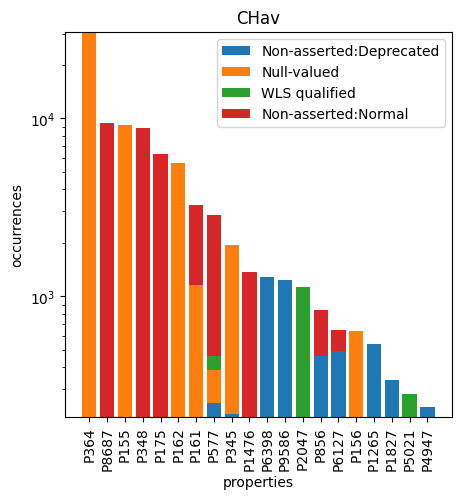

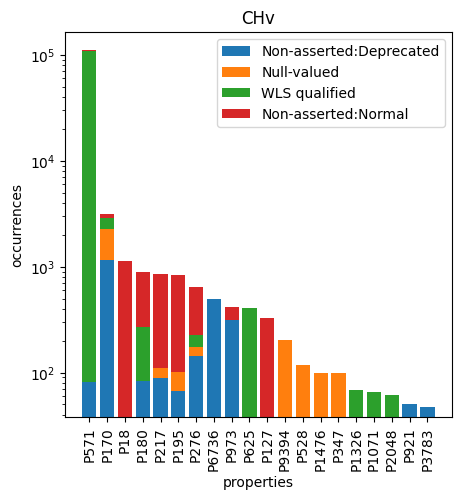

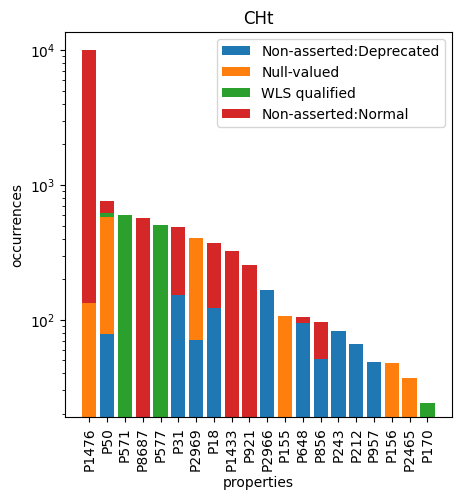

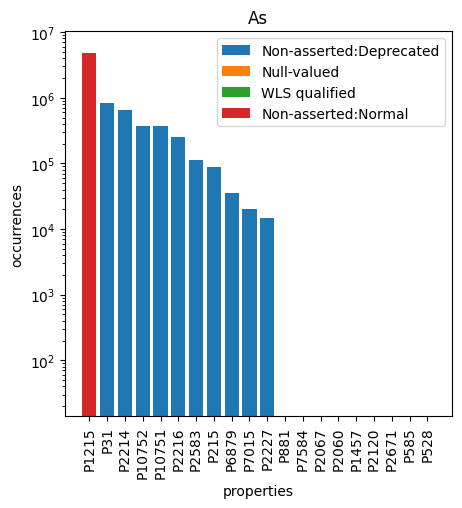

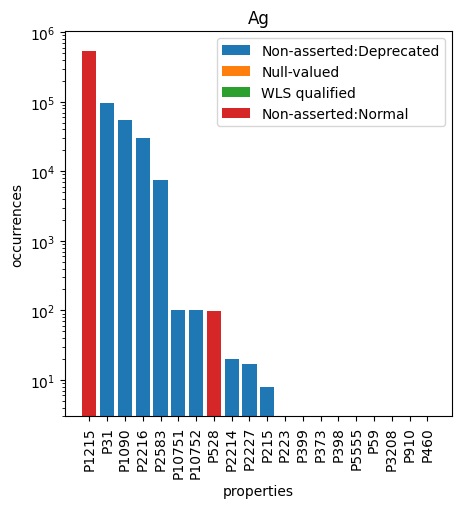

In [12]:
pop_bar = draw_bar(pop_qualif, pop_depr, pop_null, pop_norm, 'CHav')
viz_bar = draw_bar(viz_qualif, viz_depr, viz_null, viz_norm, 'CHv')
txt_bar = draw_bar(txt_qualif, txt_depr, txt_null, txt_norm, 'CHt')
s_bar = draw_bar(s_qualif, s_depr, s_null, s_norm, 'As')
g_bar = draw_bar(g_qualif, g_depr, g_null, g_norm, 'Ag')

# QUALIFIERS ANALYSIS

### Overview in the whole Wikidata

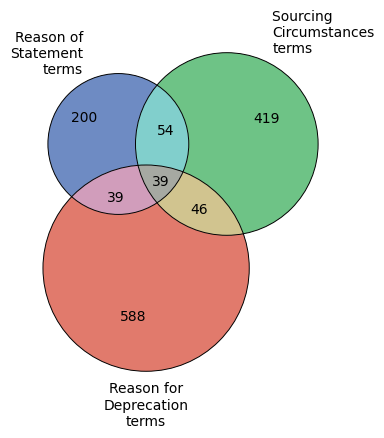

In [13]:
all_natures = ["Q202","Q404","Q795","Q5151","Q7560","Q7565","Q7727","Q8253","Q9134","Q9826","Q10737","Q11574","Q27058","Q29485","Q30612","Q34651","Q35102","Q41719","Q43115","Q44342","Q48890","Q53815","Q61002","Q69883","Q82821","Q101072","Q101244","Q102786","Q108163","Q127843","Q128758","Q129580","Q130601","Q131138","Q131288","Q132050","Q132555","Q137816","Q139060","Q144552","Q146786","Q170028","Q170393","Q170539","Q170584","Q171558","Q174779","Q179226","Q180472","Q188224","Q188577","Q188863","Q189539","Q191062","Q201676","Q202785","Q209896","Q215071","Q217102","Q222749","Q226593","Q230768","Q280943","Q311290","Q311624","Q318028","Q319141","Q331483","Q340117","Q357662","Q363802","Q367293","Q464980","Q502918","Q506461","Q517361","Q548320","Q580750","Q593147","Q603908","Q663208","Q682721","Q693726","Q701040","Q706848","Q707482","Q712144","Q720243","Q734271","Q734818","Q744069","Q748250","Q751826","Q774228","Q791801","Q797551","Q811683","Q841440","Q842346","Q855395","Q873222","Q877353","Q880643","Q927079","Q965330","Q987080","Q1069127","Q1079023","Q1125292","Q1193907","Q1199948","Q1219996","Q1236807","Q1255828","Q1306755","Q1309409","Q1321906","Q1362939","Q1370468","Q1395509","Q1520777","Q1614475","Q1630279","Q1727855","Q1784021","Q2101564","Q2254471","Q2379266","Q2500107","Q2568454","Q2631864","Q2796622","Q2839009","Q2842604","Q2969701","Q3089219","Q3144351","Q3250324","Q3281534","Q3343293","Q3422045","Q3491297","Q3497659","Q3504856","Q3544030","Q3604747","Q3620816","Q3739104","Q3739281","Q3840054","Q3918409","Q4019680","Q4676846","Q4695151","Q4736562","Q4895105","Q4917105","Q5049737","Q5049740","Q5116937","Q5135520","Q5358065","Q5615122","Q5727902","Q5994320","Q6136054","Q7458534","Q7603672","Q9695616","Q10300821","Q10348044","Q10556182","Q10578722","Q10585806","Q11146759","Q11734477","Q11999895","Q13100823","Q13579947","Q13649246","Q15104814","Q15306849","Q15632617","Q15893266","Q15989253","Q16571590","Q16582801","Q16969608","Q17024293","Q17075652","Q17125229","Q17125668","Q17776250","Q18028810","Q18122778","Q18603603","Q18603648","Q18706315","Q18912752","Q19357312","Q105078430","Q105083598","Q105223969","Q105334701","Q105564935","Q106399770","Q106466760","Q106708740","Q106708760","Q107036510","Q107217620","Q107356532","Q107380060","Q108584722","Q110143752","Q110290991","Q110290992","Q110418529","Q110781369","Q110825039","Q111014860","Q111291995","Q111305333","Q112627455","Q112883215","Q113326371","Q114875425","Q114980101","Q115211583","Q115455199","Q115471214","Q115630159","Q19953632","Q20734200","Q21514702","Q21818619","Q22979588","Q23013246","Q24025284","Q24238356","Q24575125","Q24777666","Q25895909","Q26932615","Q27136782","Q27943030","Q28831311","Q28962310","Q28962312","Q29023906","Q29509043","Q29509080","Q29569274","Q30108381","Q30230067","Q30232378","Q30278109","Q30889518","Q32188232","Q35779580","Q37113960","Q38131096","Q39811647","Q39894595","Q40719727","Q40719766","Q42590222","Q44601380","Q45025362","Q45123627","Q45406573","Q47001369","Q47035128","Q47165448","Q50095342","Q50376823","Q52834024","Q53737447","Q54835811","Q54943392","Q55093533","Q55097243","Q55713864","Q55909176","Q55935272","Q55935291","Q56557591","Q56644435","Q59237924","Q59496158","Q59864995","Q60070514","Q60614352","Q61029267","Q63971158","Q64447881","Q64467983","Q64473030","Q64643615","Q64728694","Q64760153","Q66814106","Q66814160","Q66814170","Q66814185","Q66814186","Q68575046","Q70650920","Q70918737","Q71536081","Q72842928","Q73290844","Q74524855","Q76500861","Q79030196","Q80122004","Q83489981","Q84590041","Q90177495","Q91013007","Q96102813","Q96102817","Q96943145","Q97161074","Q97284968","Q98034328","Q98047140","Q100349848","Q101437313","Q102129428","Q104378399","Q104603903"]
all_sourcing = ["Q110","Q263","Q328","Q578","Q638","Q659","Q679","Q866","Q871","Q1087","Q1661","Q1995","Q2048","Q2075","Q2087","Q2165","Q2173","Q2429","Q2436","Q2506","Q2644","Q2652","Q5151","Q5294","Q5302","Q5332","Q5435","Q5500","Q5546","Q6124","Q6126","Q6151","Q6284","Q6327","Q6380","Q6482","Q6528","Q6556","Q6628","Q6634","Q6638","Q6644","Q6679","Q6695","Q6704","Q6801","Q6815","Q6865","Q6875","Q6889","Q6932","Q6957","Q6958","Q7001","Q7006","Q7034","Q7049","Q7061","Q7063","Q7278","Q7585","Q7587","Q7589","Q7600","Q7619","Q7621","Q7627","Q7646","Q7656","Q7669","Q7672","Q7678","Q7683","Q7708","Q7716","Q7773","Q7775","Q7806","Q7831","Q8083","Q8095","Q8436","Q8447","Q8449","Q8454","Q8486","Q9492","Q9510","Q10737","Q10791","Q11081","Q11169","Q11184","Q11629","Q12138","Q12202","Q17949","Q18452","Q18577","Q18623","Q18645","Q18787","Q19301","Q19342","Q19440","Q19677","Q19750","Q23445","Q23458","Q23482","Q23563","Q23806","Q24860","Q25337","Q25641","Q27058","Q29485","Q29992","Q30388","Q30470","Q30544","Q31834","Q32032","Q32129","Q32524","Q32548","Q34302","Q34902","Q35856","Q36192","Q36424","Q36578","Q37038","Q39503","Q39911","Q41176","Q41719","Q43812","Q44342","Q45594","Q47770","Q48183","Q48528","Q49180","Q58251","Q73368","Q75634","Q76666","Q79007","Q81336","Q82821","Q102145","Q108709","Q131482","Q132382","Q132555","Q134032","Q134550","Q134762","Q141212","Q143636","Q149086","Q155656","Q157031","Q159334","Q159979","Q166735","Q167037","Q167270","Q170028","Q170393","Q170584","Q178651","Q178671","Q180494","Q185049","Q185688","Q186081","Q188236","Q188572","Q189021","Q189539","Q189643","Q191360","Q191891","Q192003","Q192613","Q199700","Q200125","Q201413","Q201676","Q202785","Q203443","Q204854","Q207315","Q214267","Q214796","Q216169","Q221725","Q224952","Q230768","Q231158","Q249405","Q273570","Q280658","Q308678","Q309100","Q319141","Q320441","Q336289","Q344495","Q357662","Q363948","Q367293","Q380559","Q384003","Q387827","Q388505","Q408386","Q460797","Q472658","Q475476","Q484284","Q506461","Q529711","Q535116","Q580922","Q603908","Q620225","Q629369","Q665247","Q678116","Q689141","Q693726","Q708653","Q712144","Q716894","Q722040","Q731126","Q734832","Q739302","Q748250","Q750663","Q777717","Q780605","Q791801","Q814441","Q820655","Q827597","Q830396","Q840148","Q847956","Q900584","Q965330","Q1050305","Q1056165","Q1125921","Q1130275","Q1145106","Q1156791","Q1156877","Q1193907","Q1229261","Q1231640","Q1232589","Q1235185","Q1236807","Q1240711","Q1255828","Q1266283","Q1297822","Q1322263","Q1332286","Q1349417","Q1361758","Q1366722","Q1373131","Q1385033","Q1395509","Q1420342","Q1423364","Q1434353","Q1440453","Q1464916","Q1466128","Q1479943","Q1520777","Q1543700","Q1639895","Q1640824","Q1681122","Q1729626","Q1747689","Q1762010","Q1939539","Q1986893","Q2132119","Q2296856","Q2339007","Q2344557","Q2389905","Q2478058","Q2492572","Q2496920","Q2534525","Q2571972","Q2657718","Q2796622","Q2821778","Q2914547","Q2919270","Q2920228","Q3061727","Q3324507","Q3364142","Q3373417","Q3509975","Q3544030","Q3663963","Q3689649","Q3704134","Q3739104","Q3749265","Q3752578","Q3776956","Q3847033","Q3962655","Q3984452","Q4010330","Q4368793","Q4401039","Q4676846","Q4895105","Q4941597","Q4994089","Q5287678","Q5297327","Q5432619","Q5727902","Q5896941","Q6136054","Q6692036","Q6878417","Q7309433","Q7585771","Q7777001","Q7882489","Q10082670","Q10578722","Q10585806","Q10677698","Q11060274","Q11086567","Q11553006","Q11564351","Q12158205","Q12300489","Q12628598","Q12772819","Q12779928","Q12827256","Q13026105","Q13050613","Q13053626","Q13634809","Q13649246","Q13780930","Q14897293","Q14903979","Q14946528","Q15051339","Q15312935","Q15729048","Q15989253","Q16189205","Q16364045","Q16368443","Q16571590","Q16693773","Q16775580","Q16868120","Q16886573","Q17125668","Q17145888","Q17152495","Q17300027","Q17373699","Q17525443","Q17584242","Q17781833","Q17853087","Q18122778","Q18195782","Q18443153","Q18603603","Q18706315","Q18912752","Q19269277","Q19426560","Q19860854","Q20204892","Q20631656","Q20734200","Q20820271","Q21042816","Q21091870","Q21096955","Q21097017","Q21097088","Q21655367","Q21683367","Q21818619","Q22812948","Q22979588","Q23013246","Q24097670","Q24575110","Q24575125","Q25328680","Q25858158","Q25895909","Q26162470","Q26877139","Q26877143","Q26907166","Q26932615","Q26944781","Q26961029","Q27055432","Q27132179","Q27145860","Q27926527","Q27965041","Q28831311","Q28962310","Q28962312","Q29023906","Q29509043","Q29509080","Q29940705","Q29998666","Q30108381","Q30230067","Q30349628","Q31275158","Q31777238","Q31884622","Q31888178","Q31888506","Q32188232","Q33853983","Q35779580","Q35946093","Q35966949","Q37113960","Q38173183","Q39811647","Q39893449","Q40422607","Q40690303","Q40719662","Q40719687","Q40719707","Q40719727","Q40719748","Q40719766","Q41696231","Q41755623","Q42727519","Q45406573","Q47035128","Q47150325","Q47546524","Q47851538","Q50095342","Q50376823","Q50843747","Q51367591","Q52008295","Q52834024","Q54418095","Q54806642","Q54835811","Q54836621","Q54943392","Q54975531","Q55235315","Q55286710","Q55935272","Q55935291","Q56295925","Q56557591","Q56580316","Q56644435","Q56685043","Q58446147","Q59564754","Q59608653","Q59783740","Q59827273","Q59864995","Q60070514","Q60503972","Q61474911","Q61793245","Q65088633","Q65706647","Q68575046","Q69652283","Q69652498","Q70650920","Q70918737","Q71533031","Q71536040","Q71536244","Q73290844","Q77066609","Q79030196","Q79030284","Q82069695","Q84423633","Q84761689","Q86454040","Q97107245","Q98344233","Q99507087","Q99773469","Q100256464","Q100349848","Q101143128","Q104378399","Q104582646","Q105483554","Q105642994","Q105675146","Q105769095","Q106160493","Q106372020","Q106419137","Q107356532","Q108172170","Q109012782","Q109104929","Q110143752","Q110290991","Q110290992","Q110558700","Q111524327","Q111524824","Q112167505","Q112249200","Q112980637","Q113292851","Q114369323","Q114786547","Q115455199","Q115464513","Q115473624"]
all_deprReason = ["Q30","Q145","Q290","Q344","Q404","Q958","Q4006","Q8192","Q8253","Q8777","Q9143","Q11184","Q11471","Q12136","Q12271","Q16346","Q17451","Q17949","Q18535","Q20357","Q27058","Q29485","Q32635","Q32993","Q33999","Q34302","Q35059","Q41719","Q42253","Q43091","Q44342","Q44497","Q48183","Q48422","Q49614","Q49836","Q56061","Q61002","Q79782","Q83900","Q93190","Q101072","Q110874","Q122192","Q125191","Q127843","Q128758","Q131138","Q132382","Q132555","Q133182","Q140641","Q152074","Q152478","Q152869","Q154242","Q156223","Q160843","Q164666","Q170028","Q174923","Q179550","Q180472","Q180711","Q181970","Q186982","Q189203","Q189349","Q190084","Q190586","Q192184","Q194189","Q203443","Q204854","Q208099","Q208826","Q210392","Q213388","Q214866","Q217102","Q217743","Q230671","Q230768","Q231835","Q272035","Q280943","Q282744","Q305418","Q308859","Q309314","Q309901","Q311463","Q319596","Q325026","Q327000","Q331483","Q334640","Q337690","Q355364","Q363948","Q410555","Q452440","Q464858","Q473432","Q476697","Q483454","Q483677","Q502918","Q506319","Q517361","Q519875","Q545779","Q557945","Q559618","Q560361","Q567555","Q570730","Q574433","Q587972","Q600499","Q610241","Q614232","Q631331","Q643290","Q647578","Q680007","Q680042","Q685744","Q693988","Q696606","Q721747","Q728937","Q734832","Q748250","Q759734","Q759815","Q776167","Q789984","Q791801","Q796919","Q811683","Q826949","Q827597","Q844326","Q846574","Q851176","Q854479","Q858082","Q862581","Q877353","Q878352","Q879295","Q880643","Q910845","Q929804","Q998790","Q1043452","Q1045481","Q1052281","Q1064904","Q1066717","Q1071027","Q1085588","Q1121708","Q1129622","Q1136723","Q1138586","Q1140419","Q1145106","Q1150070","Q1171224","Q1185297","Q1188533","Q1193907","Q1207505","Q1210382","Q1229261","Q1229735","Q1232589","Q1236807","Q1250718","Q1251417","Q1260827","Q1263068","Q1309976","Q1332286","Q1338119","Q1348305","Q1350108","Q1363768","Q1371427","Q1371586","Q1376796","Q1384499","Q1395509","Q1395577","Q1416898","Q1454489","Q1454723","Q1471017","Q1571900","Q1630279","Q1648389","Q1673271","Q1682108","Q1735821","Q1743028","Q1751943","Q1753979","Q1813536","Q1898510","Q1917420","Q1922815","Q1938536","Q1979154","Q1984758","Q2015967","Q2051704","Q2063516","Q2085518","Q2090618","Q2166722","Q2221906","Q2301707","Q2343619","Q2356726","Q2389905","Q2449404","Q2454100","Q2478058","Q2478595","Q2491016","Q2492572","Q2496920","Q2503234","Q2511187","Q2720909","Q2727213","Q2796622","Q2908560","Q2918584","Q2920228","Q2999003","Q3076763","Q3104453","Q3112030","Q3149768","Q3242304","Q3248417","Q3343293","Q3348519","Q3352817","Q3444685","Q3467464","Q3544030","Q3575478","Q3732575","Q3739281","Q3769186","Q3813865","Q3847033","Q3877969","Q3918409","Q3962655","Q4115113","Q4119183","Q4167410","Q4388326","Q4503801","Q4590027","Q4663389","Q4691861","Q4925193","Q5015649","Q5131849","Q5135520","Q5165085","Q5193258","Q5253643","Q5282797","Q5289816","Q5420623","Q5428139","Q5432619","Q5432682","Q5439369","Q5727902","Q5909236","Q5993036","Q6022092","Q6136054","Q6428674","Q6875856","Q7200789","Q7219623","Q7234480","Q7299951","Q7318524","Q7712947","Q7833925","Q7885121","Q7958155","Q8143062","Q10357784","Q10418049","Q11381163","Q11486291","Q11486300","Q11631567","Q11639308","Q12040628","Q12139592","Q12139612","Q12257711","Q12377751","Q12769393","Q12780996","Q13002315","Q13168732","Q13579947","Q13634247","Q13649246","Q14514600","Q14820227","Q14946528","Q15239622","Q15632617","Q15634554","Q15635173","Q15893266","Q15989253","Q16571590","Q16868120","Q16879044","Q16886573","Q17013103","Q17024293","Q17055519","Q17276484","Q17334923","Q17362920","Q17538709","Q17853087","Q18089644","Q18195782","Q18411409","Q18511800","Q18603603","Q18603731","Q18644427","Q18674452","Q18748141","Q18912752","Q19357621","Q19404626","Q19778981","Q19801088","Q19860854","Q20734200","Q20830903","Q20990956","Q21096955","Q21097017","Q21097088","Q21124171","Q21152551","Q21175641","Q21262209","Q21441764","Q21469979","Q21486105","Q21502838","Q21514702","Q21522908","Q21557777","Q21655367","Q21683863","Q21701659","Q21848415","Q21887121","Q21996602","Q22039296","Q22296213","Q22674925","Q22712824","Q22979588","Q23005333","Q23009439","Q23077442","Q23090331","Q24037741","Q24238356","Q24629887","Q25054195","Q25235916","Q25345174","Q25391834","Q25397937","Q25796498","Q25810847","Q25895909","Q26162470","Q26256296","Q26262236","Q26944781","Q27055388","Q27229605","Q27921563","Q27949697","Q27988255","Q28091153","Q28370743","Q28831311","Q28846358","Q28874503","Q28962312","Q29168209","Q29509080","Q29569274","Q29863201","Q29933798","Q29998666","Q30014662","Q30108381","Q30126155","Q30349290","Q30580660","Q35145263","Q35647389","Q35773207","Q35779580","Q35966949","Q37113960","Q39811647","Q39894595","Q39911916","Q41755623","Q41787617","Q42097313","Q42415624","Q42696902","Q42727519","Q44374960","Q45025362","Q45157076","Q45403344","Q45887982","Q47496130","Q48233543","Q49932764","Q50376823","Q50379085","Q51734763","Q51845721","Q51884830","Q51921823","Q51984269","Q52679949","Q53710082","Q54554025","Q54767019","Q54806642","Q54943392","Q54975531","Q54976355","Q55107540","Q55193796","Q55570340","Q56631052","Q56998693","Q57195384","Q57495609","Q58007288","Q58370623","Q58439442","Q58839938","Q59016370","Q59237924","Q59245870","Q59550254","Q59555084","Q59864995","Q60021722","Q60311385","Q60457486","Q61003021","Q61475894","Q61915880","Q62024811","Q62091220","Q62391983","Q62606058","Q63065035","Q63077779","Q64445414","Q64728500","Q64728693","Q64728694","Q64737957","Q65016715","Q65088633","Q65560376","Q65706543","Q65948447","Q66107668","Q66439731","Q66475652","Q66547754","Q67125514","Q67203058","Q67932942","Q68648103","Q70390311","Q70392051","Q70650920","Q70918737","Q71533355","Q71535331","Q71536040","Q71536244","Q71538638","Q71887839","Q72951433","Q73290844","Q73545549","Q74524855","Q74557669","Q75173816","Q75209826","Q75801665","Q76449977","Q76453668","Q76500861","Q76761345","Q77253277","Q77980264","Q78156572","Q78694451","Q80122004","Q80657659","Q80833195","Q80996755","Q80997055","Q81068910","Q82549269","Q83371408","Q84590041","Q86191979","Q87346598","Q87406427","Q87479384","Q87524790","Q87723111","Q87772960","Q88903067","Q89031984","Q89317853","Q89665509","Q89904285","Q90177495","Q91135299","Q91778853","Q91778954","Q92056121","Q93955709","Q94601911","Q95677783","Q95968315","Q95987004","Q96086516","Q96191913","Q96242333","Q97107245","Q97339959","Q97445863","Q97479954","Q98034328","Q98052232","Q98271705","Q98386534","Q98398200","Q98523542","Q98537072","Q99460987","Q99496317","Q99539439","Q99562365","Q99572267","Q99949087","Q99976017","Q100148250","Q100331739","Q100700854","Q100701259","Q101029366","Q101076817","Q103598308","Q103598309","Q103598310","Q103864591","Q103875254","Q104029445","Q104127786","Q104172943","Q104245838","Q104255002","Q104378399","Q104602651","Q104653273","Q104671559","Q104976733","Q105076526","Q105223969","Q105631494","Q105675146","Q105709687","Q105773155","Q105812742","Q105827064","Q105980786","Q106626749","Q106651934","Q106795737","Q106849510","Q106860610","Q106866757","Q106980928","Q107028274","Q107037229","Q107214772","Q107228472","Q107269364","Q107278014","Q107345922","Q107348938","Q107356532","Q107366274","Q107379991","Q107410318","Q107631537","Q107631600","Q107710355","Q107724711","Q107936414","Q108028808","Q108172170","Q108180274","Q108281296","Q108385350","Q108429588","Q108429590","Q108630154","Q108683974","Q108743139","Q108895441","Q109290665","Q109324480","Q109352971","Q109659893","Q109667022","Q110161795","Q110208058","Q110492913","Q110643252","Q110646418","Q110678154","Q110723780","Q110770329","Q111019038","Q111043064","Q111083433","Q111149276","Q111189544","Q111253654","Q111303008","Q111360696","Q111383754","Q111472389","Q111678745","Q111678787","Q112181004","Q112219947","Q112226262","Q112309110","Q112341165","Q112619903","Q112621540","Q112624709","Q112669418","Q112930606","Q112943271","Q112943275","Q113202767","Q113319997","Q113358113","Q113359274","Q113360982","Q113485150","Q113547919","Q113558184","Q113570178","Q113623390","Q113704132","Q113930396","Q113989762","Q114239895","Q114342413","Q114401995","Q114713247","Q115045024","Q115099570","Q115323571"]

out = venn3([set(all_natures), set(all_sourcing), set(all_deprReason)],
      set_colors=('#3E64AF', '#3EAF5D', '#D74E3B'), 
      set_labels = ('Reason of\nStatement\nterms', 
                    'Sourcing \nCircumstances\nterms',
                    'Reason for\nDeprecation\nterms'),
      alpha=0.75)
venn3_circles([set(all_natures), set(all_sourcing), set(all_deprReason)], lw=0.7)

for text in out.set_labels:
    text.set_fontsize(10)

plt.show()

### Set intersections

In [14]:
natures_sourcing = set(all_natures).intersection(set(all_sourcing))
deprReason_sourcing = set(all_deprReason).intersection(set(all_sourcing))
natures_deprReason = set(all_natures).intersection(set(all_deprReason))

### Nature of statements and sourcing circumstances in CH data

From a selection of "uncertain" or "false" or "debated" terms for P1502 and P1480 produces a dictionary (all_terms_labels) storing all terms with their labels

54
73


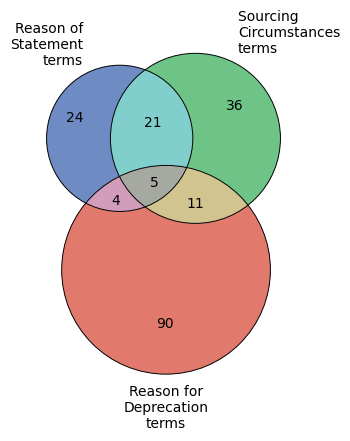

In [15]:
natures_count = {"Q27058": 0, "Q41719": 0, "Q11169": 0, "Q29485": 0, "Q357662": 0, "Q603908": 0, "Q280943": 0, "Q701040": 0, "Q873222": 0, "Q880643": 0, "Q1255828": 0, "Q3918409": 0, "Q13649246": 0, "Q17024293": 0, "Q18603603": 0, "Q18122778": 0, "Q18912752": 0, "Q25895909": 0, "Q24238356": 0, "Q24025284": 0, "Q20734200": 0, "Q26932615": 0, "Q28831311": 0, "Q28962310": 0, "Q28962312": 0, "Q29509080": 0, "Q30230067": 0, "Q30108381": 0, "Q37113960": 0, "Q45025362": 0, "Q38131096": 0, "Q50376823": 0, "Q56644435": 0, "Q54943392": 0, "Q59864995": 0, "Q73290844": 0, "Q74524855": 0, "Q84590041": 0, "Q97161074": 0, "Q100349848": 0, "Q104378399": 0, "Q107217620": 0, "Q106466760": 0, "Q107356532": 0, "Q110143752": 0, "Q110290991": 0, "Q108163": 0, "Q5727902": 0, "Q4895105": 0, "Q744069": 0, "Q748250": 0, "Q21818619": 0, "Q6136054": 0, "Q32188232": 0}
sourcing_count = {'Q9492':0,'Q11169':0,'Q27058':0,'Q17949':0,'Q41719':0,'Q224952':0, 'Q344495':0,'Q319141':0,'Q363948':0,'Q2478058':0,'Q2496920':0,'Q1434353':0,'Q1255828':0,'Q840148':0,'Q791801':0,'Q748250':0,'Q5432619':0,'Q5727902':0,'Q3984452':0,'Q3847033':0,'Q6878417':0,'Q7882489':0,'Q13649246':0,'Q18122778':0,'Q16868120':0,'Q16886573':0,'Q18603603':0,'Q18706315':0,'Q18912752':0,'Q21097017':0,'Q21655367':0,'Q21097088':0,'Q21683367':0,'Q22979588':0,'Q26932615':0,'Q25895909':0,'Q26162470':0,'Q26877139':0,'Q28962310':0,'Q28962312':0,'Q29998666':0,'Q28831311':0,'Q27055432':0,'Q28831311':0,'Q30230067':0,'Q30108381':0,'Q32188232':0,'Q37113960':0,'Q35779580':0,'Q41755623':0,'Q50376823':0,'Q54975531':0,'Q56644435':0,'Q59783740':0,'Q56685043':0,'Q60070514':0,'Q65088633':0,'Q73290844':0,'Q77066609':0,'Q70650920':0,'Q105675146':0,'Q86454040':0,'Q100349848':0,'Q104378399':0,'Q105769095':0,'Q109012782':0,'Q109104929':0,'Q110558700':0,'Q112980637':0,'Q110143752':0,'Q106160493':0,'Q107356532':0,'Q2132119':0,'Q900584':0}

reasons = ['Q48233543', 'Q7885121', 'Q78694451', 'Q65697924', 'Q23009439', 'Q106980928', 'Q734832', 'Q107356532', 'Q7299951', 'Q189203', 'Q19357621', 'Q58439442', 'Q106626749', 'Q517361', 'Q28831311', 'Q45025362', 'Q49614', 'Q21096955', 'Q1263068', 'Q5253643', 'Q72951433', 'Q54976355', 'Q80122004', 'Q16886573', 'Q87772960', 'Q107379991', 'Q60311385', 'Q3962655', 'Q105675146', 'Q1395509', 'Q25895909', 'Q2492572', 'Q1350108', 'Q22979588', 'Q14946528', 'Q94601911', 'Q89904285', 'Q41755623', 'Q99496317', 'Q30014662', 'Q103875254', 'Q29569274', 'Q29485', 'Q76449977', 'Q25345174', 'Q26162470', 'Q29509080', 'Q64445414', 'Q363948', 'Q4115113', 'Q54554025', 'Q98523542', 'Q37113960', 'Q1384499', 'Q44374960', 'Q1236807', 'Q59237924', 'Q1193907', 'Q7318524', 'Q854479', 'Q108630154', 'Q67125514', 'Q45403344', 'Q18674452', 'Q502918', 'Q54806642', 'Q54975531', 'Q27988255', 'Q862581', 'Q2496920', 'Q90177495', 'Q23090331', 'Q15893266', 'Q7234480', 'Q51845721', 'Q647578', 'Q189349', 'Q21441764', 'Q27229605', 'Q65948447', 'Q42727519', 'Q42415624', 'Q28091153', 'Q5432682', 'Q84590041', 'Q26944781', 'Q41719', 'Q12040628', 'Q8143062', 'Q87346598', 'Q35779580', 'Q21262209', 'Q108772390', 'Q35773207', 'Q105773155', 'Q21655367', 'Q1751943', 'Q81068910', 'Q26256296', 'Q108281296', 'Q92056121', 'Q61475894', 'Q109667022', 'Q96191913', 'Q29998666', 'Q104127786', 'Q86191979', 'Q28846358', 'Q62606058', 'Q208219']

print(len(natures_count))
print(len(sourcing_count))

all_terms = set(sourcing_count) | set(natures_count)
all_terms_count = {x:0 for x in all_terms}

all_terms_labels = {}

client = Client() 
for term in all_terms_count:
    try:
        entity = client.get(term, load=True)
        #print(term, entity.label.texts['en'])
        all_terms_labels.update({term:entity.label.texts['en']})
    except:
        print('error', term)
        

out = venn3([set(list(natures_count)), set(list(sourcing_count)), set(reasons)],
      set_colors=('#3E64AF', '#3EAF5D', '#D74E3B'), 
      set_labels = ('Reason of\nStatement\nterms', 
                    'Sourcing \nCircumstances\nterms',
                    'Reason for\nDeprecation\nterms'),
      alpha=0.75)
venn3_circles([set(natures_count), set(sourcing_count), set(reasons)], lw=0.7)

for text in out.set_labels:
    text.set_fontsize(10)

plt.show()